In [2]:
import pickle
import numpy as np
import torch
from utils import *
from tqdm.notebook import trange, tqdm
import random
import json
import seaborn as sns
from sklearn.metrics import top_k_accuracy_score, confusion_matrix
import pandas as pd
from classes_synsets import SYNS

In [3]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)


In [4]:
# Load Test Data

image_embeddings = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_test/image_embeddings.pt").cpu()
labels = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_test/labels.pt").cpu()

image_embeddings_val = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_val/image_embeddings.pt").cpu()
labels_val = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_val/labels.pt").cpu()

image_embeddings_train = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_train/image_embeddings.pt").cpu()
labels_train = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_train/labels.pt").cpu()


In [5]:
inds = np.array(random.choices(range(50000), k=10000))

small_ie = image_embeddings[inds]
small_labels = labels[inds]
print(small_ie.shape, small_labels.shape)

torch.Size([10000, 1024]) torch.Size([10000])


In [6]:
# Load Model

clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))

In [7]:
from classes import CLASSES, GENERIC_PROMPT_COLLECTIONS
import torch.nn as nn
from clip import clip
import os
import torch


# Initialize CLIP models 
class TextEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection
        self.dtype = clip_model.dtype
        self.token_embedding = clip_model.token_embedding

    def forward(self, text):
        x = self.token_embedding(text).type(self.dtype)  # [batch_size, n_ctx, d_model]

        x = x + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)
        x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.text_projection

        return x

def load_clip_to_cpu(visual_backbone):
    backbone_name = visual_backbone
    url = clip._MODELS[backbone_name]
    model_path = clip._download(url, os.path.expanduser("~/.cache/clip"))

    try:
        # loading JIT archive
        model = torch.jit.load(model_path, map_location="cpu").eval()
        state_dict = None

    except RuntimeError:
        state_dict = torch.load(model_path, map_location="cpu")

    model = clip.build_model(state_dict or model.state_dict())

    return model

clip_model = load_clip_to_cpu("RN50")

visual_model = torch.nn.DataParallel(clip_model.visual).cuda()

text_model = TextEncoder(clip_model)
text_model = torch.nn.DataParallel(text_model).cuda()

In [8]:
all_labels_text = {}
text_embs = []
text_labels = []
with torch.no_grad():
    for label in tqdm(range(1000)):
        all_labels_text[label] = []

        templates = ["a photo of a {}."]
        c = np.array(CLASSES)[label]
            
        texts = clip.tokenize([template.format(c) for template in templates]) 
        texts = texts.cuda()
        zeroshot_weights = clip_model.encode_text(texts).float()
        zeroshot_weights = zeroshot_weights / zeroshot_weights.norm(
            dim=-1, keepdim=True
        )
        all_labels_text[label].append(zeroshot_weights)
        text_embs.append(zeroshot_weights)
        for i in range(len(templates)):
            text_labels.append(label)
        
text_embs = torch.cat(text_embs)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
text_embs.shape

torch.Size([1000, 1024])

In [10]:
# Class frequencies

freqs = json.load(open("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/class_frequencies.json"))
freqs = {int(k):v for k,v in freqs.items()}

In [11]:
freqs

{91: 81,
 129: 161,
 683: 77,
 830: 343,
 450: 48,
 593: 292,
 566: 1173,
 600: 169,
 86: 1280,
 559: 310,
 83: 135,
 104: 61,
 466: 152,
 335: 109,
 367: 128,
 773: 175,
 52: 189,
 3: 352,
 347: 198,
 616: 354,
 387: 231,
 658: 253,
 486: 127,
 984: 714,
 947: 284,
 571: 340,
 907: 216,
 262: 102,
 828: 229,
 684: 42,
 417: 1053,
 490: 652,
 601: 683,
 879: 134,
 309: 306,
 81: 93,
 585: 101,
 236: 29,
 31: 83,
 770: 129,
 987: 233,
 191: 244,
 395: 26,
 637: 100,
 870: 642,
 715: 194,
 112: 393,
 2: 516,
 363: 169,
 388: 171,
 97: 819,
 737: 472,
 899: 272,
 929: 534,
 844: 175,
 922: 284,
 375: 232,
 979: 98,
 23: 171,
 499: 22,
 319: 290,
 209: 43,
 228: 41,
 765: 290,
 913: 215,
 725: 454,
 291: 53,
 33: 56,
 787: 271,
 318: 611,
 783: 229,
 970: 72,
 680: 61,
 875: 459,
 464: 224,
 365: 158,
 934: 141,
 628: 140,
 631: 57,
 554: 382,
 30: 287,
 451: 137,
 956: 80,
 134: 285,
 638: 90,
 107: 133,
 449: 236,
 194: 106,
 578: 252,
 75: 58,
 744: 56,
 978: 217,
 687: 264,
 976: 625,


In [12]:
many_labels = []
many_embs = []
many_inds = []
med_labels = []
med_embs = []
med_inds = []
few_labels = []
few_embs = []
few_inds = []

for i in tqdm(range(image_embeddings.shape[0])):
    if freqs[labels[i].item()] >= 100:
        many_labels.append(labels[i])
        many_embs.append(image_embeddings[i, :])
        many_inds.append(i)
    elif freqs[labels[i].item()] >= 20:
        med_labels.append(labels[i])
        med_embs.append(image_embeddings[i, :])
        med_inds.append(i)
    else:
        few_labels.append(labels[i])
        few_embs.append(image_embeddings[i, :])
        few_inds.append(i)
        
many_embs = torch.stack(many_embs)
med_embs = torch.stack(med_embs)
few_embs = torch.stack(few_embs)

many_inds = np.array(many_inds)
med_inds = np.array(med_inds)
few_inds = np.array(few_inds)


  0%|          | 0/50000 [00:00<?, ?it/s]

In [13]:
fg_buckets = [5, 10, 15, 20, 30, 40, 60, 100, 160, 10000]

fg_indices_val = {k: [] for k in fg_buckets}

seen = set()

for i in tqdm(range(image_embeddings_val.shape[0])):
    for k in fg_buckets:
        if freqs[labels_val[i].item()] <= k and i not in seen:
            seen.add(i)
            fg_indices_val[k].append(i)
print(len([i for k in fg_indices_val for i in fg_indices_val[k]]))
[len(fg_indices_val[k]) for k in fg_indices_val]

  0%|          | 0/20000 [00:00<?, ?it/s]

20000


[100, 1040, 880, 900, 1580, 1680, 2560, 3560, 3340, 4360]

In [14]:


fg_indices = {k: [] for k in fg_buckets}

seen = set()

for i in tqdm(range(image_embeddings.shape[0])):
    for k in fg_buckets:
        if freqs[labels[i].item()] <= k and i not in seen:
            seen.add(i)
            fg_indices[k].append(i)
print(len([i for k in fg_indices for i in fg_indices[k]]))
[len(fg_indices[k]) for k in fg_indices]

  0%|          | 0/50000 [00:00<?, ?it/s]

50000


[250, 2600, 2200, 2250, 3950, 4200, 6400, 8900, 8350, 10900]

In [15]:
def bucket_indices(l):
    seen = set()
    out = []
    for i in tqdm(range(len(l))):
        for k,kk in enumerate(fg_buckets):
            if freqs[l[i].item()] <= kk and i not in seen:
                seen.add(i)
                out.append(k)
    return out

In [16]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,10)

### Alternate Train(?) scheme: Only FT on Image and only FT on Text

In [17]:
def all_accs(model):
    preds = model.predict(image_embeddings)
    l = labels.numpy()
    avg_acc = mic_acc_cal(preds, l)
    many = mic_acc_cal(preds[many_inds], many_labels)
    med = mic_acc_cal(preds[med_inds], med_labels)
    few = mic_acc_cal(preds[few_inds], few_labels)
    print(f"{avg_acc:.3f}/{many:.3f}/{med:.3f}/{few:.3f}")
    return [avg_acc, many, med, few]

In [18]:
def all_accs_p(preds):
    l = labels.numpy()
    avg_acc = mic_acc_cal(preds, l)
    many = mic_acc_cal(preds[many_inds], many_labels)
    med = mic_acc_cal(preds[med_inds], med_labels)
    few = mic_acc_cal(preds[few_inds], few_labels)
    print(f"{avg_acc:.3f}/{many:.3f}/{med:.3f}/{few:.3f}")
    return [avg_acc, many, med, few]

In [19]:
def all_accs_fg(preds, ls, fg_indices):
    avg_acc = mic_acc_cal(preds, ls)
    out_accs = [avg_acc]
    for k in fg_indices:
        indices = np.array(fg_indices[k])
        acc = mic_acc_cal(preds[indices], ls[indices])
        out_accs.append(acc)
    print([f"{k:.5f}" for k in out_accs])
    return out_accs

In [22]:
conv_comb_0_8_clf = pickle.load(open("results_sklearn/config_convex_comb_1/class_balanced/13-Sep-2022-13-41-17/final_model.sav", 'rb'))

# text_only_balanced_clf = pickle.load(open("results_sklearn/config_text_only_0/29-Sep-2022-01-32-28/final_model.sav", 'rb'))
text_only_balanced_clf = pickle.load(open("results_sklearn/config_text_only_liblinear/06-Nov-2022-01-47-08/final_model.sav", 'rb'))
text_only_balanced_cupl = pickle.load(open("results_sklearn/config_text_only_clip_and_cupl_liblinear/07-Nov-2022-12-41-14/final_model.sav", 'rb'))


image_only_clf = pickle.load(open("results_sklearn/config_image_linear_probe_0/class_balanced/13-Sep-2022-01-35-07/final_model.sav", 'rb'))
image_only_clf_2 = pickle.load(open("results_sklearn/config_image_linear_probe_0/balanced/29-Sep-2022-01-38-27/final_model.sav", 'rb'))
image_only_clf_3 = pickle.load(open("results_sklearn/config_image_linear_probe_0/balanced/07-Nov-2022-18-27-46/final_model.sav", 'rb'))
image_only_clf_4 = pickle.load(open("results_sklearn/config_image_linear_probe_0/balanced/11-Nov-2022-16-23-33/final_model.sav", 'rb'))

image_only_clf_oversampled = pickle.load(open("results_sklearn/config_image_linear_probe_oversampled_auto/class_balanced/07-Nov-2022-20-13-26/final_model.sav", 'rb'))
# image_only_clf_oversampled_500 = pickle.load(open("results_sklearn/config_image_linear_probe_0/balanced/11-Nov-2022-16-23-33/final_model.sav", 'rb'))

image_only_clf_undersampled_500 = pickle.load(open("results_sklearn/config_image_linear_probe_undersampled_0-5/12-Nov-2022-12-17-52/final_model.sav", 'rb'))
image_only_clf_undersampled = pickle.load(open("results_sklearn/config_image_linear_probe_undersampled_auto/class_balanced/07-Nov-2022-20-18-24/final_model.sav", 'rb'))

image_only_clf_oversampled = pickle.load(open("results_sklearn/config_image_linear_probe_0/c_10/13-Nov-2022-20-07-26/final_model.sav", 'rb'))
# image_only_clf_oversampled = pickle.load(open("results_sklearn/config_image_linear_probe_nojitter/01-Dec-2022-22-31-07/final_model.sav", 'rb'))

conv_comb_0_8_clf_oversampled = pickle.load(open("/nethome/bdevnani3/flash1/long_tail_lang/results_sklearn/config_convex_comb_oversampled_auto/02-Dec-2022-05-42-24/final_model.sav", 'rb'))




In [23]:
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
all_accs = []
for i in range(0, 21):
    i = i/20.0
    print(f"Mixing coeff: {i:.2f}")
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*conv_comb_0_8_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*conv_comb_0_8_clf_oversampled.intercept_
    preds = mixed_clf.predict(image_embeddings)
    temp_acc = all_accs_fg(preds, labels.numpy(), fg_indices)
    all_accs.append(temp_acc)

Mixing coeff: 0.00
['0.63438', '0.30000', '0.47423', '0.55636', '0.60756', '0.59165', '0.63976', '0.64031', '0.63528', '0.66036', '0.69083']
Mixing coeff: 0.05
['0.63530', '0.30800', '0.47692', '0.55864', '0.60622', '0.59266', '0.64071', '0.64141', '0.63685', '0.65976', '0.69183']
Mixing coeff: 0.10
['0.63656', '0.31200', '0.47846', '0.55818', '0.60756', '0.59519', '0.64143', '0.64438', '0.63798', '0.66072', '0.69239']
Mixing coeff: 0.15
['0.63728', '0.30800', '0.48231', '0.55955', '0.60844', '0.59747', '0.64214', '0.64594', '0.63820', '0.66084', '0.69211']
Mixing coeff: 0.20
['0.63806', '0.31600', '0.48769', '0.56000', '0.61156', '0.59823', '0.64238', '0.64781', '0.63730', '0.66156', '0.69220']
Mixing coeff: 0.25
['0.63862', '0.31600', '0.48885', '0.56455', '0.60978', '0.59899', '0.64405', '0.64812', '0.63820', '0.66204', '0.69174']
Mixing coeff: 0.30
['0.63952', '0.32000', '0.49346', '0.56500', '0.61111', '0.59975', '0.64500', '0.64953', '0.63831', '0.66228', '0.69257']
Mixing coeff:

In [23]:
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
all_accs_val = []
for i in range(0, 21):
    i = i/20.0
    print(f"Mixing coeff: {i:.2f}")
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    preds = mixed_clf.predict(image_embeddings_val)
    temp_acc = all_accs_fg(preds, labels_val.numpy(), fg_indices_val)
    all_accs_val.append(temp_acc)

Mixing coeff: 0.00
['0.63425', '0.15000', '0.28942', '0.41250', '0.54111', '0.56266', '0.59464', '0.61133', '0.66376', '0.73473', '0.74518']
Mixing coeff: 0.05
['0.63675', '0.15000', '0.29615', '0.41932', '0.54556', '0.56582', '0.59940', '0.61328', '0.66573', '0.73593', '0.74610']
Mixing coeff: 0.10
['0.63865', '0.16000', '0.29808', '0.42159', '0.54889', '0.56899', '0.60119', '0.61602', '0.66713', '0.73653', '0.74794']
Mixing coeff: 0.15
['0.64080', '0.16000', '0.30288', '0.42727', '0.55444', '0.57405', '0.60595', '0.62070', '0.66798', '0.73593', '0.74771']
Mixing coeff: 0.20
['0.64265', '0.16000', '0.30673', '0.43068', '0.55222', '0.57975', '0.60952', '0.62148', '0.67107', '0.73443', '0.74977']
Mixing coeff: 0.25
['0.64435', '0.15000', '0.31346', '0.43750', '0.56111', '0.58228', '0.61131', '0.62109', '0.67247', '0.73503', '0.75000']
Mixing coeff: 0.30
['0.64615', '0.15000', '0.32308', '0.43977', '0.56333', '0.58861', '0.61310', '0.62539', '0.67416', '0.73144', '0.75092']
Mixing coeff:

(21, 10)
[18 19 19 14 16 14 14  8  2  8]
(21, 10)


/nethome/bdevnani3/flash1/miniconda3/envs/ltr/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


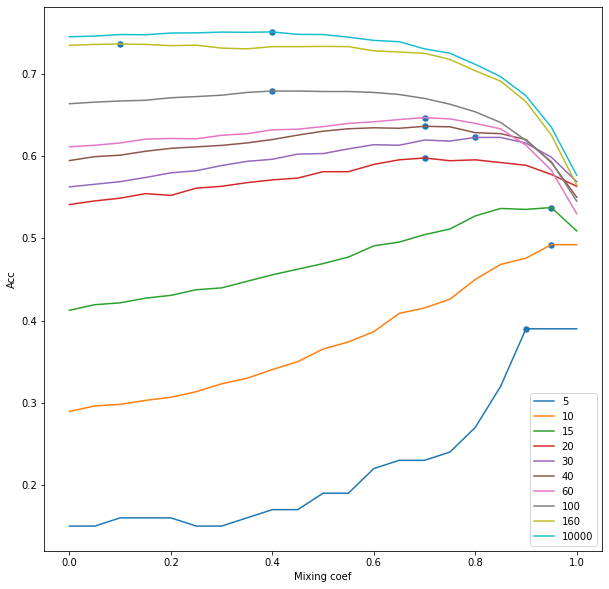

In [29]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,10)
x = np.array([i/20.0 for i in range(0, 21)])

aa = np.array(all_accs_val)[:, 1:]
print(aa.shape)
m = np.argmax(aa, axis=0)
y = []
print(m)
print(aa.shape)
for i in range(len(fg_buckets)):
    y.append(aa[m[i], i])
xx = x[m]
sns.scatterplot(xx, y = y, marker='o', s=50)
for i in range(len(fg_indices_val)):
    y = [j[i] for j in aa]
    ax = sns.lineplot(x = x, y = y, label=fg_buckets[i])
ax.set(xlabel='Mixing coef', ylabel='Acc')
plt.show()



In [247]:
# normalize model weights
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
all_accs_test = []
for i in range(0, 21):
    i = i/20.0
    print(f"Mixing coeff: {i:.2f}")
    mixed_clf.coef_ = i*conv_comb_0_8_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*conv_comb_0_8_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    preds = mixed_clf.predict(image_embeddings)
    temp_acc = all_accs_fg(preds, labels.numpy(), fg_indices)
    all_accs_test.append(temp_acc)

Mixing coeff: 0.00
['0.62514', '0.14400', '0.28731', '0.43636', '0.53556', '0.50810', '0.59357', '0.61734', '0.65764', '0.70503', '0.74477']
Mixing coeff: 0.05
['0.62884', '0.15600', '0.29615', '0.44318', '0.54267', '0.51899', '0.59929', '0.62094', '0.65888', '0.70731', '0.74550']
Mixing coeff: 0.10
['0.63196', '0.16400', '0.30346', '0.45409', '0.55022', '0.52734', '0.60405', '0.62203', '0.66180', '0.70790', '0.74578']
Mixing coeff: 0.15
['0.63508', '0.16000', '0.31692', '0.46409', '0.55689', '0.53367', '0.60929', '0.62516', '0.66371', '0.70814', '0.74569']
Mixing coeff: 0.20
['0.63770', '0.16800', '0.32615', '0.47227', '0.56133', '0.54329', '0.61357', '0.63031', '0.66494', '0.70719', '0.74431']
Mixing coeff: 0.25
['0.63974', '0.16800', '0.33385', '0.47682', '0.57022', '0.54987', '0.61929', '0.63438', '0.66596', '0.70659', '0.74174']
Mixing coeff: 0.30
['0.64150', '0.17200', '0.34346', '0.48500', '0.57156', '0.55418', '0.62381', '0.63844', '0.66640', '0.70623', '0.73972']
Mixing coeff:

In [26]:
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
all_accs_test = []
for i in range(0, 21):
    i = i/20.0
    print(f"Mixing coeff: {i:.2f}")
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    preds = mixed_clf.predict(image_embeddings)
    temp_acc = all_accs_fg(preds, labels.numpy(), fg_indices)
    all_accs_test.append(temp_acc)

Mixing coeff: 0.00
['0.62354', '0.12000', '0.29385', '0.41682', '0.52356', '0.51823', '0.58667', '0.61516', '0.65674', '0.70251', '0.74578']
Mixing coeff: 0.05
['0.62600', '0.12800', '0.29923', '0.42409', '0.52667', '0.52127', '0.59000', '0.61766', '0.66022', '0.70323', '0.74624']
Mixing coeff: 0.10
['0.62804', '0.13200', '0.30308', '0.42818', '0.52978', '0.52481', '0.59452', '0.62031', '0.66135', '0.70455', '0.74661']
Mixing coeff: 0.15
['0.63046', '0.14000', '0.30769', '0.43091', '0.53467', '0.52987', '0.59833', '0.62156', '0.66404', '0.70611', '0.74743']
Mixing coeff: 0.20
['0.63208', '0.14800', '0.31269', '0.43500', '0.53689', '0.53291', '0.60286', '0.62359', '0.66539', '0.70551', '0.74752']
Mixing coeff: 0.25
['0.63414', '0.15200', '0.32038', '0.44000', '0.54044', '0.53696', '0.60714', '0.62562', '0.66685', '0.70623', '0.74725']
Mixing coeff: 0.30
['0.63622', '0.15600', '0.32769', '0.44364', '0.54489', '0.54203', '0.60976', '0.62844', '0.66787', '0.70790', '0.74670']
Mixing coeff:

(21, 10)
[20 20 18 14 16 14 13  8  8  7]
(21, 10)


/nethome/bdevnani3/flash1/miniconda3/envs/ltr/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


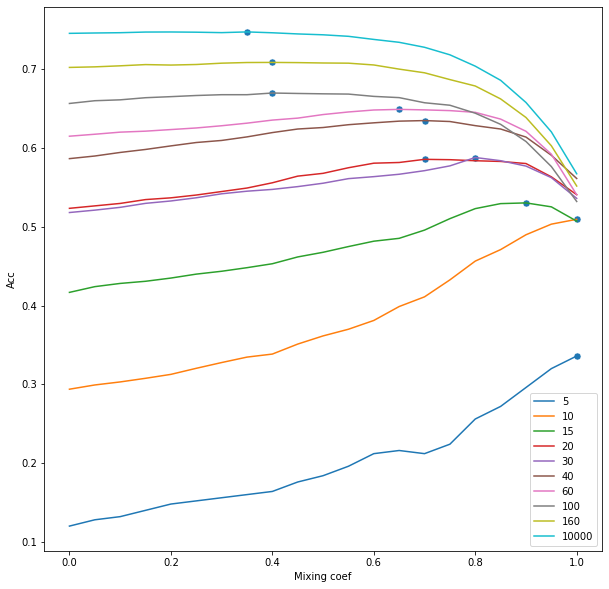

In [28]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,10)
x = np.array([i/20.0 for i in range(0, 21)])

aa = np.array(all_accs_test)[:, 1:]
print(aa.shape)
m = np.argmax(aa, axis=0)
y = []
print(m)
print(aa.shape)
for i in range(len(fg_buckets)):
    y.append(aa[m[i], i])
xx = x[m]
sns.scatterplot(xx, y = y, marker='o', s=50)
for i in range(len(fg_indices_val)):
    y = [j[i] for j in aa]
    ax = sns.lineplot(x = x, y = y, label=fg_buckets[i])
ax.set(xlabel='Mixing coef', ylabel='Acc')
plt.show()

In [47]:
best_mixing_coefs_val = np.argmax(all_accs_val, axis=0)
x = np.array([i/20.0 for i in range(0, 21)])
x[best_mixing_coefs_val]

array([0.65, 0.9 , 0.95, 0.95, 0.7 , 0.8 , 0.7 , 0.7 , 0.4 , 0.1 , 0.4 ])

In [48]:
best_mixing_coefs_test = np.argmax(all_accs_test, axis=0)
x = np.array([i/20.0 for i in range(0, 21)])
x[best_mixing_coefs_test]

array([0.6 , 1.  , 1.  , 0.9 , 0.7 , 0.8 , 0.7 , 0.65, 0.4 , 0.4 , 0.35])

In [103]:
def class_wise_accuracy(preds, labels):
    accs = np.zeros(1000)
    corr = preds == labels
    for i in range(len(labels)):
        if corr[i] == True:
            accs[labels[i]] +=1
    accs /= (len(labels)/1000)
    return accs

  0%|          | 0/21 [00:00<?, ?it/s]

<AxesSubplot:xlabel='freqs_per_class', ylabel='best_coefs_per_class'>

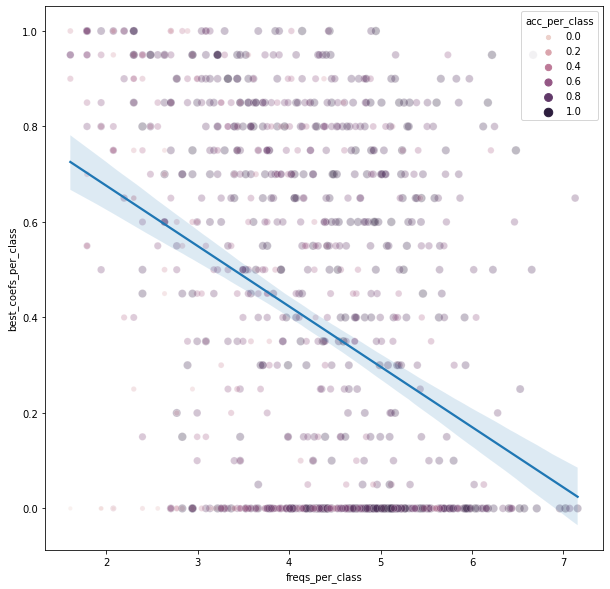

In [50]:
# Assess best coefficient per class

coefs = []
val_instance_preds = []
class_wise_accs = []
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
for i in tqdm(range(0, 21)):
    i = i/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    preds = mixed_clf.predict(image_embeddings_val)
    cwa = class_wise_accuracy(preds, labels_val.numpy())
    class_wise_accs.append(cwa)
    val_instance_preds.append(preds)
    
coefs = np.array([i/20.0 for i in range(0, 21)])
indices_of_best_coefs = np.argmax(np.array(class_wise_accs), axis=0)

acc_per_class = np.max(np.array(class_wise_accs), axis=0)
best_coefs_per_class = np.array(coefs)[np.argmax(np.array(class_wise_accs), axis=0)]
freqs_per_class = np.log([freqs[i] for i in range(1000)])

df = pd.DataFrame(list(zip(best_coefs_per_class, freqs_per_class, acc_per_class)),
               columns =['best_coefs_per_class', 'freqs_per_class',  'acc_per_class'])

sns.scatterplot(data=df, x = 'freqs_per_class', y = 'best_coefs_per_class', hue='acc_per_class', size='acc_per_class', alpha=0.3)
sns.regplot(data=df, x = 'freqs_per_class', y = 'best_coefs_per_class', scatter=False)

In [51]:
np.mean(np.max(np.array(class_wise_accs), axis=0))

0.7215499999999999

  0%|          | 0/21 [00:00<?, ?it/s]

<AxesSubplot:xlabel='freqs_per_class', ylabel='best_coefs_per_class'>

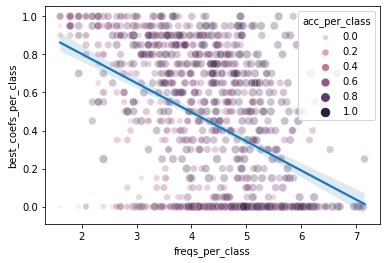

In [105]:
# Assess best coefficient per class

coefs = []
test_instance_preds = []
class_wise_accs_test = []
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
for i in tqdm(range(0, 21)):
    i = i/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    preds = mixed_clf.predict(image_embeddings)
    cwa = class_wise_accuracy(preds, labels.numpy())
    class_wise_accs_test.append(cwa)
    test_instance_preds.append(preds)
    
coefs = np.array([i/20.0 for i in range(0, 21)])
indices_of_best_coefs = np.argmax(np.array(class_wise_accs_test), axis=0)

acc_per_class = np.max(np.array(class_wise_accs_test), axis=0)
best_coefs_per_class = np.array(coefs)[np.argmax(np.array(class_wise_accs_test), axis=0)]
freqs_per_class = np.log([freqs[i] for i in range(1000)])

df = pd.DataFrame(list(zip(best_coefs_per_class, freqs_per_class, acc_per_class)),
               columns =['best_coefs_per_class', 'freqs_per_class',  'acc_per_class'])

sns.scatterplot(data=df, x = 'freqs_per_class', y = 'best_coefs_per_class', hue='acc_per_class', size='acc_per_class', alpha=0.3)
sns.regplot(data=df, x = 'freqs_per_class', y = 'best_coefs_per_class', scatter=False)

In [ ]:
np.mean(np.max(np.array(class_wise_accs_test), axis=0))

In [54]:
class_wise_accs_test = class_wise_accs

out = []
for i in range(1000):
    for j in indices_of_best_coefs:
        out.append(class_wise_accs_test[j][i])
        
np.mean(out)

0.6381244

In [21]:
### Adaptively choose mixing coefficient using val set

# explore the confidence of prediction across the various mixtures

# Best Many:
i = 0.45
many_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
many_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
many_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_

# Best Med:
i = 0.65
med_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
med_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
med_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_

# Best Few:
i = 0.95
few_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
few_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
few_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_

acc = 0
for i in tqdm(range(50000)):
    if freqs[labels[i].item()] >= 100:
        pred = many_clf.predict(image_embeddings[i,:].unsqueeze(0))
    elif freqs[labels[i].item()] >= 20:
        pred = med_clf.predict(image_embeddings[i,:].unsqueeze(0))
    else:
        pred = few_clf.predict(image_embeddings[i,:].unsqueeze(0))
    if pred[0] == labels[i].item():
        acc+=1
        
print(acc/50000)

  0%|          | 0/50000 [00:00<?, ?it/s]

0.65644


In [22]:
best_possible_acc/50000.0

NameError: name 'best_possible_acc' is not defined

In [100]:
all_accs_p(np.array(acc_preds))

0.740/0.791/0.731/0.623


[0.73978, 0.7909462915601023, 0.7311205073995771, 0.6227941176470588]

In [ ]:
graph = sns.pointplot(data=df_corr_det, x = "num dsgrmnts", y = "correct_coefs", alpha = 0.1)

graph = sns.scatterplot(data=df_corr_det, x = "num dsgrmnts", y = "correct_coefs", alpha = 0.1)
blah = df_corr_det
# graph = sns.kdeplot(data=blah, x = "num dsgrmnts", y = "correct_coefs", fill=True, common_norm=False, palette="crest", alpha=.5)

plt.xlim([-1, 10])
plt.ylim([-1, 1])

In [249]:
df_corr_det[df_corr_det["num dsgrmnts"] == 10]

,correct_coefs,freq,num dsgrmnts


In [274]:
disagreement_test = []
for preds in zip(*pred_list):
    disagreement_test.append(len(np.unique(preds)))
print(len(disagreement_test))

disagreement_val = []
for preds in zip(*pred_list_val):
    disagreement_val.append(len(np.unique(preds)))
print(len(disagreement_val))

50000
20000


### Train a Linear layer to predict mixing coefficients 

In [23]:
from sklearn.linear_model import LinearRegression

### (i) Just image and text scores

In [41]:
# TRAIN/VAL SET

# image classification scores

scores = image_only_clf_oversampled.predict_proba(image_embeddings_val)
print("Image Classification Scores: ", scores.shape)

# text classification scores

text_scores_val = text_only_balanced_clf.predict_proba(image_embeddings_val)
print("Text Classification Scores: ", text_scores_val.shape)

# combine
input_features = np.concatenate((scores, text_scores_val), axis=-1)
print("Combined input Features:", input_features.shape)

# Get correct coefficients for correctly classified samples from val set

indices = [] # indices corresponding to coefs
corr_coefs = [] # coefs corresponding to input

coefs = np.array([i/20.0 for i in range(0, 21)])
remove_from_train = []
for i, z in tqdm(enumerate(zip(*val_instance_preds))):
    z = np.array(z)
    inds = np.where(z == labels_val[i].item())[0]
    if len(inds) > 0 :
        correct_coefs = coefs[inds]
        indices.append(i)
        corr_coefs.append([np.mean(correct_coefs), np.max(correct_coefs)-np.mean(correct_coefs)])
    else:
        remove_from_train.append(i)
        corr_coefs.append([-1, -1])
        
indices = np.array(indices)
corr_coefs = np.array(corr_coefs)

print("Size of viable data:", len(indices), len(corr_coefs))


from sklearn.model_selection import train_test_split
split_inds = np.array(range(image_embeddings_val.shape[0]))
X_train, X_val, _, _ = train_test_split(split_inds, split_inds, test_size=0.20, random_state=0)

print("Train/Val split:", len(X_train), len(X_val))

X_train_filt = []
for x in X_train:
    if x not in remove_from_train:
        X_train_filt.append(x)
        
print(len(X_train), len(X_train_filt))

print("Viable train data:", len(X_train), len(X_train_filt))

ie_train = image_embeddings_val[X_train_filt]
vlabels_train = labels_val[X_train_filt]
corr_coefs_train = corr_coefs[X_train_filt]
input_features_train = input_features[X_train_filt]

print("Train Dims")
print(ie_train.shape)
print(vlabels_train.shape)
print(corr_coefs_train.shape)
print(input_features_train.shape)

ie_val = image_embeddings_val[X_val]
input_features_val = input_features[X_val]
vlabels_val = labels_val[X_val]
corr_coefs_val = corr_coefs[X_val]

print("Val Dims")
print(ie_val.shape)
print(vlabels_val.shape)
print(input_features_val.shape)
print(corr_coefs_val.shape)


Image Classification Scores:  (20000, 1000)
Text Classification Scores:  (20000, 1000)
Combined input Features: (20000, 2000)


0it [00:00, ?it/s]

Size of viable data: 15009 20000
Train/Val split: 16000 4000
16000 12011
Viable train data: 16000 12011
Train Dims
torch.Size([12011, 1024])
torch.Size([12011])
(12011, 2)
(12011, 2000)
Val Dims
torch.Size([4000, 1024])
torch.Size([4000])
(4000, 2000)
(4000, 2)


In [26]:
## TEST SET

# Get correct coefficients for correctly classified samples from test set

test_indices = [] # indices corresponding to coefs
corr_coefs_test = [] # coefs corresponding to input

coefs = np.array([i/20.0 for i in range(0, 21)])

for i, z in tqdm(enumerate(zip(*test_instance_preds))):
    z = np.array(z)
    inds = np.where(z == labels[i].item())[0]
    if len(inds) > 0 :
        correct_coefs = coefs[inds]
        test_indices.append(i)
        corr_coefs_test.append([np.mean(correct_coefs), np.max(correct_coefs)-np.mean(correct_coefs)])
        
test_indices = np.array(test_indices)
test_targets = np.array(corr_coefs_test)

# Image scores
test_scores = image_only_clf_oversampled.predict_proba(image_embeddings)

# Text scores
text_scores_test = text_only_balanced_clf.predict_proba(image_embeddings)

# Combine
input_features_test = np.concatenate((test_scores, text_scores_test), axis=-1)

# Align
test_inputs = input_features_test[test_indices, :]
corr_coefs_test = np.array(corr_coefs_test)

print(test_inputs.shape)
print(corr_coefs_test.shape)
print(input_features_test.shape)

0it [00:00, ?it/s]

(36989, 2000)
(36989, 2)
(50000, 2000)


In [489]:
%store test_indices
%store test_targets

Stored 'test_indices' (ndarray)
Stored 'test_targets' (ndarray)


In [ ]:
import torch
import torch.nn as nn
import copy 

class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
#         self.bn = nn.LayerNorm(100)
#         self.do = nn.Dropout(p=0.05)
#         self.linear2 = nn.Linear(100, output_dim)
        self.m = nn.Sigmoid()
        self.mse = nn.MSELoss()

    def forward(self, x):
        x = self.linear(x)
#         x = self.bn(x)
#         x = self.linear2(x)
        out = self.m(x)
        return out

def loss_fn(output, target):
    mse = nn.MSELoss()
    loss1 = mse(output,target)
    return loss1

epochs = 5000
model = LinearRegressionModel(2000, 2)
learning_rate = 0.01
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max= epochs)
best_model = model
best_acc = 0

for epoch in range(epochs):
    model.train()
    # Convert numpy array to torch Variable
    inputs = torch.from_numpy(input_features_train).float().requires_grad_()
    targets = torch.from_numpy(corr_coefs_train).float()

    # Clear gradients w.r.t. parameters
    optimizer.zero_grad() 

    # Forward to get output
    outputs = model(inputs)

    # Calculate Loss
    loss = loss_fn(outputs, targets)

    # Getting gradients w.r.t. parameters
    loss.backward()

    # Updating parameters
    optimizer.step()
    sched.step()

    if epoch%100 == 0:
        model.eval()
        val_coef_preds = model(torch.from_numpy(input_features_val).float())
        val_acc = evaluate_acc(val_coef_preds, vlabels_val, ie_val)
        if val_acc > best_acc:
            print("Updating best model")
            best_acc = val_acc
            best_model = copy.deepcopy(model)
        print(f'epoch {epoch}, loss {loss.item():.5f}, v_acc {val_acc:.3f}')

In [113]:
model.eval()
with torch.no_grad():
    train_coef_preds = best_model(torch.from_numpy(input_features_train).float())
    print(train_coef_preds.shape)        
    val_coef_preds = best_model(torch.from_numpy(input_features_val).float())
    print(val_coef_preds.shape)  
    test_coef_preds = best_model(torch.from_numpy(input_features_test).float())
    print(test_coef_preds.shape)        

torch.Size([12760, 2])
torch.Size([3000, 2])
torch.Size([50000, 2])


In [30]:
def evaluate_acc(coef_preds, labels, ie, v = False, test=False):
    mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
    acc = 0
    preds = []
    for j in tqdm(range(coef_preds.shape[0])):
        i = coef_preds[j][0].item() 
        mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
        mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
        pred = mixed_clf.predict(ie[j].reshape(1, -1))
        preds.append(pred[0])
        if pred[0] == labels[j].item():
            acc+=1
        if j>0 and j%1000== 0 and v:
            blah = acc*100/j
            print(f"{blah:.3f}, {j}")
    if test:
        all_accs_p(np.array(preds))
    return acc*100/j

In [115]:
print(evaluate_acc(train_coef_preds, vlabels_train, ie_train))
print(evaluate_acc(val_coef_preds, vlabels_val, ie_val))
print(evaluate_acc(test_coef_preds, labels.numpy(), image_embeddings, test = True))

  0%|          | 0/12760 [00:00<?, ?it/s]

88.10251587114978


  0%|          | 0/3000 [00:00<?, ?it/s]

66.08869623207735


  0%|          | 0/50000 [00:00<?, ?it/s]

0.646/0.725/0.634/0.457
64.57729154583092


### (ii) Optimizer variant

In [116]:
import torch
import torch.nn as nn

epochs = 5000
model = LinearRegressionModel(2000, 2)
learning_rate = 0.005
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max= epochs)
best_model = model
best_acc = 0

def loss_fn(output, target):
    mse = nn.MSELoss()
    loss1 = mse(output,target)
    return loss1

for epoch in range(epochs):
    model.train()
    # Convert numpy array to torch Variable
    inputs = torch.from_numpy(input_features_train).float().requires_grad_()
    targets = torch.from_numpy(corr_coefs_train).float()

    # Clear gradients w.r.t. parameters
    optimizer.zero_grad() 

    # Forward to get output
    outputs = model(inputs)

    # Calculate Loss
    loss = loss_fn(outputs, targets)

    # Getting gradients w.r.t. parameters
    loss.backward()

    # Updating parameters
    optimizer.step()
    sched.step()

    if epoch%100 == 0:
        model.eval()
        val_coef_preds = model(torch.from_numpy(input_features_val).float())
        val_acc = evaluate_acc(val_coef_preds, vlabels_val, ie_val)
        if val_acc > best_acc:
            print("Updating best model")
            best_acc = val_acc
            best_model = copy.deepcopy(model)
        print(f'epoch {epoch}, loss {loss.item():.5f}, v_acc {val_acc:.3f}')
        
model.eval()
with torch.no_grad():
    train_coef_preds = best_model(torch.from_numpy(input_features_train).float())
    print(train_coef_preds.shape)        
    val_coef_preds = best_model(torch.from_numpy(input_features_val).float())
    print(val_coef_preds.shape)  
    test_coef_preds = best_model(torch.from_numpy(input_features_test).float())
    print(test_coef_preds.shape)    

  0%|          | 0/3000 [00:00<?, ?it/s]

Updating best model
epoch 0, loss 0.02430, v_acc 65.522


  0%|          | 0/3000 [00:00<?, ?it/s]

Updating best model
epoch 100, loss 0.02270, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

Updating best model
epoch 200, loss 0.02175, v_acc 65.622


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 300, loss 0.02125, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 400, loss 0.02099, v_acc 65.622


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 500, loss 0.02085, v_acc 65.622


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 600, loss 0.02077, v_acc 65.622


  0%|          | 0/3000 [00:00<?, ?it/s]

Updating best model
epoch 700, loss 0.02073, v_acc 65.655


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 800, loss 0.02071, v_acc 65.655


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 900, loss 0.02070, v_acc 65.622


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 1000, loss 0.02069, v_acc 65.622


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 1100, loss 0.02069, v_acc 65.622


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 1200, loss 0.02068, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 1300, loss 0.02068, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 1400, loss 0.02068, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 1500, loss 0.02068, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 1600, loss 0.02068, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 1700, loss 0.02068, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 1800, loss 0.02068, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 1900, loss 0.02068, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 2000, loss 0.02068, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 2100, loss 0.02067, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 2200, loss 0.02067, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 2300, loss 0.02067, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 2400, loss 0.02067, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 2500, loss 0.02067, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 2600, loss 0.02067, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 2700, loss 0.02067, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 2800, loss 0.02067, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 2900, loss 0.02067, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 3000, loss 0.02067, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 3100, loss 0.02067, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 3200, loss 0.02067, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 3300, loss 0.02067, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 3400, loss 0.02067, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 3500, loss 0.02067, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 3600, loss 0.02067, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 3700, loss 0.02067, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 3800, loss 0.02067, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 3900, loss 0.02067, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 4000, loss 0.02067, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 4100, loss 0.02067, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 4200, loss 0.02067, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 4300, loss 0.02067, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 4400, loss 0.02067, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 4500, loss 0.02067, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 4600, loss 0.02067, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 4700, loss 0.02067, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 4800, loss 0.02067, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 4900, loss 0.02067, v_acc 65.589
torch.Size([12760, 2])
torch.Size([3000, 2])
torch.Size([50000, 2])


In [117]:
print(evaluate_acc(train_coef_preds, vlabels_train, ie_train))
print(evaluate_acc(val_coef_preds, vlabels_val, ie_val))
print(evaluate_acc(test_coef_preds, labels.numpy(), image_embeddings, test = True))

  0%|          | 0/12760 [00:00<?, ?it/s]

87.35010580766517


  0%|          | 0/3000 [00:00<?, ?it/s]

65.65521840613538


  0%|          | 0/50000 [00:00<?, ?it/s]

0.644/0.725/0.634/0.444
64.37728754575092


### (iii) Loss fn variant

In [118]:
import torch
import torch.nn as nn

def loss_fn(output, target):
    weight = 1/(target[:,1]**2)
    weight[target[:,1] == 0] = 1
    loss1 = torch.mean(weight*((output[:,0]-target[:,0]) ** 2))
    return loss1

epochs = 5000
model = LinearRegressionModel(2000, 2)
learning_rate = 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max= epochs)
best_model = model
best_acc = 0

for epoch in range(epochs):
    model.train()
    # Convert numpy array to torch Variable
    inputs = torch.from_numpy(input_features_train).float().requires_grad_()
    targets = torch.from_numpy(corr_coefs_train).float()

    # Clear gradients w.r.t. parameters
    optimizer.zero_grad() 

    # Forward to get output
    outputs = model(inputs)

    # Calculate Loss
    loss = loss_fn(outputs, targets)

    # Getting gradients w.r.t. parameters
    loss.backward()

    # Updating parameters
    optimizer.step()
    sched.step()

    if epoch%100 == 0:
        model.eval()
        val_coef_preds = model(torch.from_numpy(input_features_val).float())
        val_acc = evaluate_acc(val_coef_preds, vlabels_val, ie_val)
        if val_acc > best_acc:
            print("Updating best model")
            best_acc = val_acc
            best_model = copy.deepcopy(model)
        print(f'epoch {epoch}, loss {loss.item():.5f}, v_acc {val_acc:.3f}')
        


  0%|          | 0/3000 [00:00<?, ?it/s]

Updating best model
epoch 0, loss 6.36713, v_acc 65.622


  0%|          | 0/3000 [00:00<?, ?it/s]

Updating best model
epoch 100, loss 5.07095, v_acc 66.155


  0%|          | 0/3000 [00:00<?, ?it/s]

Updating best model
epoch 200, loss 4.24767, v_acc 66.422


  0%|          | 0/3000 [00:00<?, ?it/s]

Updating best model
epoch 300, loss 3.73697, v_acc 66.556


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 400, loss 3.40890, v_acc 66.322


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 500, loss 3.18344, v_acc 66.255


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 600, loss 3.01598, v_acc 66.055


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 700, loss 2.88267, v_acc 65.889


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 800, loss 2.77094, v_acc 65.789


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 900, loss 2.67406, v_acc 65.755


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 1000, loss 2.58834, v_acc 65.655


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 1100, loss 2.51158, v_acc 65.622


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 1200, loss 2.44236, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 1300, loss 2.37964, v_acc 65.555


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 1400, loss 2.32263, v_acc 65.488


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 1500, loss 2.27066, v_acc 65.488


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 1600, loss 2.22319, v_acc 65.655


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 1700, loss 2.17975, v_acc 65.722


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 1800, loss 2.13995, v_acc 65.689


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 1900, loss 2.10343, v_acc 65.655


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 2000, loss 2.06989, v_acc 65.655


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 2100, loss 2.03908, v_acc 65.655


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 2200, loss 2.01076, v_acc 65.622


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 2300, loss 1.98473, v_acc 65.689


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 2400, loss 1.96080, v_acc 65.555


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 2500, loss 1.93883, v_acc 65.622


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 2600, loss 1.91867, v_acc 65.622


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 2700, loss 1.90019, v_acc 65.622


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 2800, loss 1.88328, v_acc 65.655


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 2900, loss 1.86783, v_acc 65.622


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 3000, loss 1.85376, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 3100, loss 1.84098, v_acc 65.555


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 3200, loss 1.82941, v_acc 65.555


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 3300, loss 1.81899, v_acc 65.555


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 3400, loss 1.80964, v_acc 65.522


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 3500, loss 1.80131, v_acc 65.522


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 3600, loss 1.79393, v_acc 65.555


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 3700, loss 1.78746, v_acc 65.622


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 3800, loss 1.78183, v_acc 65.622


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 3900, loss 1.77700, v_acc 65.555


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 4000, loss 1.77291, v_acc 65.555


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 4100, loss 1.76950, v_acc 65.522


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 4200, loss 1.76673, v_acc 65.555


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 4300, loss 1.76453, v_acc 65.555


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 4400, loss 1.76285, v_acc 65.555


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 4500, loss 1.76162, v_acc 65.522


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 4600, loss 1.76078, v_acc 65.522


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 4700, loss 1.76027, v_acc 65.522


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 4800, loss 1.76000, v_acc 65.522


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 4900, loss 1.75990, v_acc 65.488


In [119]:
model.eval()
with torch.no_grad():
    train_coef_preds = best_model(torch.from_numpy(input_features_train).float())
    print(train_coef_preds.shape)        
    val_coef_preds = best_model(torch.from_numpy(input_features_val).float())
    print(val_coef_preds.shape)  
    test_coef_preds = best_model(torch.from_numpy(input_features_test).float())
    print(test_coef_preds.shape)    
print(evaluate_acc(train_coef_preds, vlabels_train, ie_train))
print(evaluate_acc(val_coef_preds, vlabels_val, ie_val))
print(evaluate_acc(test_coef_preds, labels.numpy(), image_embeddings, test = True))

torch.Size([12760, 2])
torch.Size([3000, 2])
torch.Size([50000, 2])


  0%|          | 0/12760 [00:00<?, ?it/s]

87.64009718629987


  0%|          | 0/3000 [00:00<?, ?it/s]

66.55551850616872


  0%|          | 0/50000 [00:00<?, ?it/s]

0.646/0.717/0.638/0.471
64.59729194583892


### (iv) Loss fn variant

In [120]:
import torch
import torch.nn as nn

def loss_fn(output, target):
    weight = 1/torch.abs(target[:,1])
    weight[target[:,1] == 0] = 1
    loss1 = torch.mean(weight*(torch.abs(output[:,0]-target[:,0])))
    return loss1

epochs = 5000
model = LinearRegressionModel(2000, 2)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max= epochs)
best_model = model
best_acc = 0

for epoch in range(epochs):
    model.train()
    # Convert numpy array to torch Variable
    inputs = torch.from_numpy(input_features_train).float().requires_grad_()
    targets = torch.from_numpy(corr_coefs_train).float()

    # Clear gradients w.r.t. parameters
    optimizer.zero_grad() 

    # Forward to get output
    outputs = model(inputs)

    # Calculate Loss
    loss = loss_fn(outputs, targets)

    # Getting gradients w.r.t. parameters
    loss.backward()

    # Updating parameters
    optimizer.step()
    sched.step()

    if epoch%100 == 0:
        model.eval()
        val_coef_preds = model(torch.from_numpy(input_features_val).float())
        val_acc = evaluate_acc(val_coef_preds, vlabels_val, ie_val)
        if val_acc > best_acc:
            print("Updating best model")
            best_acc = val_acc
            best_model = copy.deepcopy(model)
        print(f'epoch {epoch}, loss {loss.item():.5f}, v_acc {val_acc:.3f}')
        

  0%|          | 0/3000 [00:00<?, ?it/s]

Updating best model
epoch 0, loss 0.69373, v_acc 65.555


  0%|          | 0/3000 [00:00<?, ?it/s]

Updating best model
epoch 100, loss 0.68140, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

Updating best model
epoch 200, loss 0.67047, v_acc 65.889


  0%|          | 0/3000 [00:00<?, ?it/s]

Updating best model
epoch 300, loss 0.65973, v_acc 65.922


  0%|          | 0/3000 [00:00<?, ?it/s]

Updating best model
epoch 400, loss 0.64965, v_acc 65.955


  0%|          | 0/3000 [00:00<?, ?it/s]

Updating best model
epoch 500, loss 0.64033, v_acc 65.989


  0%|          | 0/3000 [00:00<?, ?it/s]

Updating best model
epoch 600, loss 0.63181, v_acc 66.089


  0%|          | 0/3000 [00:00<?, ?it/s]

Updating best model
epoch 700, loss 0.62408, v_acc 66.155


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 800, loss 0.61714, v_acc 65.989


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 900, loss 0.61085, v_acc 65.955


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 1000, loss 0.60522, v_acc 65.989


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 1100, loss 0.60027, v_acc 65.955


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 1200, loss 0.59587, v_acc 65.955


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 1300, loss 0.59194, v_acc 65.989


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 1400, loss 0.58844, v_acc 65.955


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 1500, loss 0.58532, v_acc 65.989


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 1600, loss 0.58252, v_acc 66.022


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 1700, loss 0.58002, v_acc 66.022


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 1800, loss 0.57776, v_acc 65.855


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 1900, loss 0.57572, v_acc 65.822


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 2000, loss 0.57385, v_acc 65.789


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 2100, loss 0.57217, v_acc 65.755


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 2200, loss 0.57064, v_acc 65.789


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 2300, loss 0.56925, v_acc 65.822


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 2400, loss 0.56798, v_acc 65.655


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 2500, loss 0.56684, v_acc 65.655


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 2600, loss 0.56581, v_acc 65.655


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 2700, loss 0.56488, v_acc 65.655


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 2800, loss 0.56404, v_acc 65.622


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 2900, loss 0.56327, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 3000, loss 0.56257, v_acc 65.555


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 3100, loss 0.56194, v_acc 65.589


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 3200, loss 0.56136, v_acc 65.555


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 3300, loss 0.56086, v_acc 65.555


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 3400, loss 0.56041, v_acc 65.555


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 3500, loss 0.56001, v_acc 65.522


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 3600, loss 0.55967, v_acc 65.455


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 3700, loss 0.55937, v_acc 65.455


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 3800, loss 0.55911, v_acc 65.455


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 3900, loss 0.55889, v_acc 65.455


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 4000, loss 0.55871, v_acc 65.388


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 4100, loss 0.55856, v_acc 65.388


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 4200, loss 0.55844, v_acc 65.355


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 4300, loss 0.55834, v_acc 65.355


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 4400, loss 0.55827, v_acc 65.355


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 4500, loss 0.55822, v_acc 65.355


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 4600, loss 0.55818, v_acc 65.355


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 4700, loss 0.55816, v_acc 65.355


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 4800, loss 0.55815, v_acc 65.355


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 4900, loss 0.55814, v_acc 65.355


In [121]:
model.eval()
with torch.no_grad():
    train_coef_preds = best_model(torch.from_numpy(input_features_train).float())
    print(train_coef_preds.shape)        
    val_coef_preds = best_model(torch.from_numpy(input_features_val).float())
    print(val_coef_preds.shape)  
    test_coef_preds = best_model(torch.from_numpy(input_features_test).float())
    print(test_coef_preds.shape)    
print(evaluate_acc(train_coef_preds, vlabels_train, ie_train))
print(evaluate_acc(val_coef_preds, vlabels_val, ie_val))
print(evaluate_acc(test_coef_preds, labels.numpy(), image_embeddings, test = True))



torch.Size([12760, 2])
torch.Size([3000, 2])
torch.Size([50000, 2])


  0%|          | 0/12760 [00:00<?, ?it/s]

87.84387491182694


  0%|          | 0/3000 [00:00<?, ?it/s]

66.15538512837612


  0%|          | 0/50000 [00:00<?, ?it/s]

0.646/0.722/0.637/0.461
64.60129202584052


### (v) Architecture Variant

In [43]:
import torch
import torch.nn as nn
import copy

class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 100)
        self.bn = nn.LayerNorm(100)
        self.do = nn.Dropout(p=0.2)
        self.linear2 = nn.Linear(100, output_dim)
        self.m = nn.Sigmoid()
        self.mse = nn.MSELoss()

    def forward(self, x):
        x = self.linear(x)
        x = self.bn(x)
        x = self.do(x)
        x = self.linear2(x)
        out = self.m(x)
        return out

def loss_fn(output, target):
    weight = 1/torch.abs(target[:,1])
    weight[target[:,1] == 0] = 1
    loss1 = torch.mean(weight*(torch.abs(output[:,0]-target[:,0])))
    return loss1

epochs = 5000
model = LinearRegressionModel(2000, 2)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max= epochs)
best_model = model
best_acc = 0

for epoch in range(epochs):
    model.train()
    # Convert numpy array to torch Variable
    inputs = torch.from_numpy(input_features_train).float().requires_grad_()
    targets = torch.from_numpy(corr_coefs_train).float()

    # Clear gradients w.r.t. parameters
    optimizer.zero_grad() 

    # Forward to get output
    outputs = model(inputs)

    # Calculate Loss
    loss = loss_fn(outputs, targets)

    # Getting gradients w.r.t. parameters
    loss.backward()

    # Updating parameters
    optimizer.step()
    sched.step()

    if epoch%100 == 0:
        model.eval()
        val_coef_preds = model(torch.from_numpy(input_features_val).float())
        val_acc = evaluate_acc(val_coef_preds, vlabels_val, ie_val)
        if val_acc > best_acc:
            print("Updating best model")
            best_acc = val_acc
            best_model = copy.deepcopy(model)
        print(f'epoch {epoch}, loss {loss.item():.5f}, v_acc {val_acc:.3f}, best_v_acc {best_acc:.3f}')
        

  0%|          | 0/4000 [00:00<?, ?it/s]

Updating best model
epoch 0, loss 0.78101, v_acc 66.317, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 100, loss 0.43219, v_acc 65.416, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 200, loss 0.34593, v_acc 65.841, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 300, loss 0.31217, v_acc 66.067, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 400, loss 0.29164, v_acc 66.042, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 500, loss 0.27599, v_acc 66.217, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 600, loss 0.26566, v_acc 66.217, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 700, loss 0.25815, v_acc 66.167, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 800, loss 0.25380, v_acc 66.267, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 900, loss 0.24777, v_acc 66.067, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 1000, loss 0.24284, v_acc 66.167, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 1100, loss 0.23892, v_acc 66.167, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 1200, loss 0.23473, v_acc 66.117, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 1300, loss 0.23349, v_acc 66.217, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 1400, loss 0.23140, v_acc 66.142, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 1500, loss 0.22760, v_acc 66.167, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 1600, loss 0.22465, v_acc 66.017, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 1700, loss 0.22338, v_acc 66.092, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 1800, loss 0.22321, v_acc 65.841, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 1900, loss 0.21932, v_acc 66.142, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 2000, loss 0.21824, v_acc 66.067, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 2100, loss 0.21737, v_acc 66.192, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 2200, loss 0.21503, v_acc 66.042, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 2300, loss 0.21346, v_acc 66.017, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 2400, loss 0.21281, v_acc 66.092, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 2500, loss 0.21061, v_acc 66.067, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 2600, loss 0.21106, v_acc 66.017, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 2700, loss 0.21013, v_acc 66.117, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 2800, loss 0.20805, v_acc 66.017, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 2900, loss 0.20726, v_acc 65.966, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 3000, loss 0.20579, v_acc 66.017, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 3100, loss 0.20486, v_acc 65.966, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 3200, loss 0.20432, v_acc 66.067, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 3300, loss 0.20319, v_acc 65.991, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 3400, loss 0.20239, v_acc 66.042, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 3500, loss 0.20221, v_acc 66.067, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 3600, loss 0.20241, v_acc 66.017, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 3700, loss 0.20131, v_acc 66.042, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 3800, loss 0.20085, v_acc 66.017, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 3900, loss 0.19974, v_acc 66.042, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 4000, loss 0.19971, v_acc 66.017, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 4100, loss 0.19948, v_acc 66.067, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 4200, loss 0.19932, v_acc 66.042, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 4300, loss 0.19879, v_acc 66.042, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 4400, loss 0.19801, v_acc 66.067, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 4500, loss 0.19753, v_acc 66.067, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 4600, loss 0.19763, v_acc 66.042, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 4700, loss 0.19716, v_acc 66.067, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 4800, loss 0.19768, v_acc 66.067, best_v_acc 66.317


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 4900, loss 0.19823, v_acc 66.067, best_v_acc 66.317


In [44]:
model.eval()
with torch.no_grad():
    train_coef_preds = best_model(torch.from_numpy(input_features_train).float())
    print(train_coef_preds.shape)        
    val_coef_preds = best_model(torch.from_numpy(input_features_val).float())
    print(val_coef_preds.shape)  
    test_coef_preds = best_model(torch.from_numpy(input_features_test).float())
    print(test_coef_preds.shape)    
a1 = evaluate_acc(train_coef_preds, vlabels_train, ie_train)
a2 = evaluate_acc(val_coef_preds, vlabels_val, ie_val)
a3 = evaluate_acc(test_coef_preds, labels.numpy(), image_embeddings, test = True)

print(a1, a2, a3)

torch.Size([12011, 2])
torch.Size([4000, 2])
torch.Size([50000, 2])


  0%|          | 0/12011 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

0.646/0.712/0.639/0.481
87.5270607826811 66.3165791447862 64.59929198583971


### LBFGS Variant

In [51]:
import torch
import torch.nn as nn
import copy 

class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.m = nn.Sigmoid()
        self.mse = nn.MSELoss()

    def forward(self, x):
        x = self.linear(x)
        out = self.m(x)
        return out

def loss_fn(output, target):
    mse = nn.MSELoss()
    loss1 = mse(output,target)
    return loss1

epochs = 5000
model = LinearRegressionModel(2000, 2)
learning_rate = 0.005
# sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max= epochs)
best_model = model
best_acc = 0
optimizer = torch.optim.LBFGS(model.parameters(),
                    history_size=10, 
                    max_iter=4, lr = 0.5)

inputs = torch.from_numpy(input_features_train).float()
targets = torch.from_numpy(corr_coefs_train).float()


for epoch in range(epochs):
    model.train()
    
    # Forward to get output
    outputs = model(inputs)
    
    def closure():
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        loss.backward(retain_graph=True)
        return loss
    
    # Calculate Loss
    loss = loss_fn(outputs, targets)
    
    # Updating parameters
    optimizer.step(closure)
#     sched.step()

    

    if epoch%200 == 0:
        model.eval()
        val_coef_preds = model(torch.from_numpy(input_features_val).float())
        val_acc = evaluate_acc(val_coef_preds, vlabels_val, ie_val)
        if val_acc > best_acc:
            print("Updating best model")
            best_acc = val_acc
            best_model = copy.deepcopy(model)
        print(f'epoch {epoch}, loss {loss.item():.5f}, v_acc {val_acc:.3f}')

  0%|          | 0/4000 [00:00<?, ?it/s]

Updating best model
epoch 0, loss 0.02441, v_acc 65.491


  0%|          | 0/4000 [00:00<?, ?it/s]

Updating best model
epoch 200, loss 0.01773, v_acc 65.666


  0%|          | 0/4000 [00:00<?, ?it/s]

Updating best model
epoch 400, loss 0.01744, v_acc 65.716


  0%|          | 0/4000 [00:00<?, ?it/s]

Updating best model
epoch 600, loss 0.01723, v_acc 65.816


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 800, loss 0.01702, v_acc 65.816


  0%|          | 0/4000 [00:00<?, ?it/s]

Updating best model
epoch 1000, loss 0.01687, v_acc 65.891


  0%|          | 0/4000 [00:00<?, ?it/s]

Updating best model
epoch 1200, loss 0.01681, v_acc 65.916


  0%|          | 0/4000 [00:00<?, ?it/s]

Updating best model
epoch 1400, loss 0.01678, v_acc 65.941


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 1600, loss 0.01675, v_acc 65.891


  0%|          | 0/4000 [00:00<?, ?it/s]

Updating best model
epoch 1800, loss 0.01658, v_acc 65.991


  0%|          | 0/4000 [00:00<?, ?it/s]

Updating best model
epoch 2000, loss 0.01654, v_acc 66.017


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 2200, loss 0.01652, v_acc 66.017


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 2400, loss 0.01645, v_acc 65.991


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 2600, loss 0.01642, v_acc 66.017


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 2800, loss 0.01640, v_acc 66.017


  0%|          | 0/4000 [00:00<?, ?it/s]

epoch 3000, loss 0.01638, v_acc 66.017


  0%|          | 0/4000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [54]:
best_model.eval()
model.eval()
with torch.no_grad():
    train_coef_preds = best_model(torch.from_numpy(input_features_train).float())
    print(train_coef_preds.shape)        
    val_coef_preds = best_model(torch.from_numpy(input_features_val).float())
    print(val_coef_preds.shape)  
    test_coef_preds = best_model(torch.from_numpy(input_features_test).float())
    print(test_coef_preds.shape)    
# a1 = evaluate_acc(train_coef_preds, vlabels_train, ie_train)
# a2 = evaluate_acc(val_coef_preds, vlabels_val, ie_val)
a3 = evaluate_acc(test_coef_preds, labels.numpy(), image_embeddings, test = True, v=True)

print(a1, a2, a3)

torch.Size([12011, 2])
torch.Size([4000, 2])
torch.Size([50000, 2])


  0%|          | 0/50000 [00:00<?, ?it/s]

63.300, 1000
63.900, 2000
63.933, 3000
64.050, 4000
64.160, 5000
63.950, 6000
64.371, 7000
64.412, 8000
64.189, 9000
64.020, 10000
63.955, 11000
63.925, 12000
64.000, 13000
64.093, 14000
64.253, 15000
64.256, 16000
64.276, 17000
64.522, 18000
64.458, 19000
64.460, 20000
64.510, 21000
64.641, 22000
64.722, 23000
64.612, 24000
64.552, 25000
64.569, 26000
64.585, 27000
64.575, 28000
64.531, 29000
64.643, 30000
64.629, 31000
64.659, 32000
64.636, 33000
64.618, 34000
64.620, 35000
64.522, 36000
64.484, 37000
64.550, 38000
64.603, 39000
64.620, 40000
64.637, 41000
64.669, 42000
64.714, 43000
64.700, 44000
64.693, 45000
64.687, 46000
64.628, 47000
64.627, 48000
64.592, 49000
0.646/0.725/0.635/0.457
87.5270607826811 66.3165791447862 64.59329186583732


### Incorporating disagreements

In [59]:
# Load disagreements 

disagreements = np.load("pred_proba_arr_val.npz")
disagreements = disagreements['arr1']

disagreements_test = np.load("pred_proba_arr.npz")
disagreements_test = disagreements_test['arr1']

In [140]:
import numpy as np
pred_list = []
for model_preds in tqdm(disagreements):
    temp = []
    for inst in model_preds:
        temp.append(np.argmax(inst))
    pred_list.append(temp)
pred_list = np.array(pred_list)
print(pred_list.shape)
dg_val = []
for preds in zip(*pred_list):
    dg_val.append(len(np.unique(preds)))
dg_val = np.array(dg_val)/np.max(dg_val)
dg_val.shape

  0%|          | 0/43 [00:00<?, ?it/s]

(43, 20000)


(20000,)

In [141]:
# TRAIN/VAL SET

# image classification scores

# scores = image_only_clf_oversampled.predict_proba(image_embeddings_val)
print("Image Classification Scores: ", scores.shape)

# text classification scores

# text_scores_val = text_only_balanced_clf.predict_proba(image_embeddings_val)
print("Text Classification Scores: ", text_scores_val.shape)

# disagreements scores
# dg_val = np.unique(np.transpose(dg_val, (1,0)), axis=-1)
# print("Text Disagreement Scores: ", dg.shape)
dg_val = np.expand_dims(dg_val,-1)

# combine
# input_features = np.concatenate((scores, text_scores_val, dg_val), axis=-1)
input_features = np.concatenate((image_embeddings_val.numpy(),scores, text_scores_val, dg_val), axis=-1)
print("Combined input Features:", input_features.shape)

# Get correct coefficients for correctly classified samples from val set

indices = [] # indices corresponding to coefs
corr_coefs = [] # coefs corresponding to input

coefs = np.array([i/20.0 for i in range(0, 21)])
remove_from_train = []
for i, z in tqdm(enumerate(zip(*val_instance_preds))):
    z = np.array(z)
    inds = np.where(z == labels_val[i].item())[0]
    if len(inds) > 0 :
        correct_coefs = coefs[inds]
        indices.append(i)
        corr_coefs.append([np.mean(correct_coefs), np.max(correct_coefs)-np.mean(correct_coefs)])
    else:
        remove_from_train.append(i)
        corr_coefs.append([-1, -1])
        
indices = np.array(indices)
# corr_coefs = np.array(corr_coefs)
corr_coefs = np.array(corr_coefs)

print("Size of viable data:", len(indices), len(corr_coefs))


from sklearn.model_selection import train_test_split
split_inds = np.array(range(image_embeddings_val.shape[0]))
X_train, X_val, _, _ = train_test_split(split_inds, split_inds, test_size=0.15, random_state=0)

print("Train/Val split:", len(X_train), len(X_val))

X_train_filt = []
for x in X_train:
    if x not in remove_from_train:
        X_train_filt.append(x)
        
print(len(X_train), len(X_train_filt))

print("Viable train data:", len(X_train), len(X_train_filt))

ie_train = image_embeddings_val[X_train_filt]
vlabels_train = labels_val[X_train_filt]
corr_coefs_train = corr_coefs[X_train_filt]
input_features_train = input_features[X_train_filt]

print("Train Dims")
print(ie_train.shape)
print(vlabels_train.shape)
print(corr_coefs_train.shape)
print(input_features_train.shape)

ie_val = image_embeddings_val[X_val]
input_features_val = input_features[X_val]
vlabels_val = labels_val[X_val]
corr_coefs_val = corr_coefs[X_val]

print("Val Dims")
print(ie_val.shape)
print(vlabels_val.shape)
print(input_features_val.shape)
print(corr_coefs_val.shape)


Image Classification Scores:  (20000, 1000)
Text Classification Scores:  (20000, 1000)
Combined input Features: (20000, 3025)


0it [00:00, ?it/s]

Size of viable data: 15009 20000
Train/Val split: 17000 3000
17000 12760
Viable train data: 17000 12760
Train Dims
torch.Size([12760, 1024])
torch.Size([12760])
(12760, 2)
(12760, 3025)
Val Dims
torch.Size([3000, 1024])
torch.Size([3000])
(3000, 3025)
(3000, 2)


In [142]:
## TEST SET

# Get correct coefficients for correctly classified samples from test set

test_indices = [] # indices corresponding to coefs
corr_coefs_test = [] # coefs corresponding to input

coefs = np.array([i/20.0 for i in range(0, 21)])

for i, z in tqdm(enumerate(zip(*test_instance_preds))):
    z = np.array(z)
    inds = np.where(z == labels[i].item())[0]
    if len(inds) > 0 :
        correct_coefs = coefs[inds]
        test_indices.append(i)
        corr_coefs_test.append([np.mean(correct_coefs), np.max(correct_coefs)-np.mean(correct_coefs)])
        
test_indices = np.array(test_indices)
test_targets = np.array(corr_coefs_test)

# # Image scores
# test_scores = image_only_clf_oversampled.predict_proba(image_embeddings)

# # Text scores
# text_scores_test = text_only_balanced_clf.predict_proba(image_embeddings)

pred_list = []
for model_preds in tqdm(disagreements_test):
    temp = []
    for inst in model_preds:
        temp.append(np.argmax(inst))
    pred_list.append(temp)
dg_test = []
for preds in zip(*pred_list):
    dg_test.append(len(np.unique(preds)))
dg_test = np.array(dg_test)
dg_test = dg_test/np.max(dg_test)
dg_test = np.expand_dims(dg_test,-1).T

# disagreements scores
dg_test = np.unique(np.transpose(dg_test, (1,0)),axis=-1)
print(dg_test.shape)

# Combine
input_features_test = np.concatenate((image_embeddings.numpy(), test_scores, text_scores_test, dg_test), axis=-1)

# Align
test_inputs = input_features_test[test_indices, :]
corr_coefs_test = np.array(corr_coefs_test)

print(test_inputs.shape)
print(corr_coefs_test.shape)
print(input_features_test.shape)

0it [00:00, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

(50000, 1)
(36989, 3025)
(36989, 2)
(50000, 3025)


In [143]:
import torch
import torch.nn as nn
import copy

class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 100)
#         self.bn = nn.LayerNorm(100)
#         self.do = nn.Dropout(p=0.2)
        self.linear2 = nn.Linear(100, output_dim)
        self.m = nn.Sigmoid()
        self.mse = nn.MSELoss()

    def forward(self, x):
        x = self.linear(x)
#         x = self.bn(x)
#         x = self.do(x)
        x = self.linear2(x)
        out = self.m(x)
        return out

def loss_fn(output, target):
    weight = 1/torch.abs(target[:,1])
    weight[target[:,1] == 0] = 1
    loss1 = torch.mean(weight*(torch.abs(output[:,0]-target[:,0])))
    return loss1

# def loss_fn(output, target):
#     weight = 1/(target[:,1]**2)
#     weight[target[:,1] == 0] = 1
#     loss1 = torch.mean(weight*((output[:,0]-target[:,0]) ** 2))
#     return loss1

epochs = 5000
model = LinearRegressionModel(3025, 2)
learning_rate = 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max= epochs)
best_model = model
best_acc = 0

for epoch in range(epochs):
    model.train()
    # Convert numpy array to torch Variable
    inputs = torch.from_numpy(input_features_train).float().requires_grad_()
    targets = torch.from_numpy(corr_coefs_train).float()

    # Clear gradients w.r.t. parameters
    optimizer.zero_grad() 

    # Forward to get output
    outputs = model(inputs)

    # Calculate Loss
    loss = loss_fn(outputs, targets)

    # Getting gradients w.r.t. parameters
    loss.backward()

    # Updating parameters
    optimizer.step()
    sched.step()

    if epoch%100 == 0:
        model.eval()
        val_coef_preds = model(torch.from_numpy(input_features_val).float())
        val_acc = evaluate_acc(val_coef_preds, vlabels_val, ie_val)
        if val_acc > best_acc:
            print("Updating best model")
            best_acc = val_acc
            best_model = copy.deepcopy(model)
        print(f'epoch {epoch}, loss {loss.item():.5f}, v_acc {val_acc:.3f}, best_v_acc {best_acc:.3f}')
        

  0%|          | 0/3000 [00:00<?, ?it/s]

Updating best model
epoch 0, loss 0.72964, v_acc 65.455, best_v_acc 65.455


  0%|          | 0/3000 [00:00<?, ?it/s]

Updating best model
epoch 100, loss 0.57395, v_acc 66.255, best_v_acc 66.255


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 200, loss 0.52412, v_acc 65.589, best_v_acc 66.255


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 300, loss 0.51063, v_acc 65.288, best_v_acc 66.255


KeyboardInterrupt: 

In [145]:
best_model.eval()
model.eval()
with torch.no_grad():
    train_coef_preds = best_model(torch.from_numpy(input_features_train).float())
    print(train_coef_preds.shape)        
    val_coef_preds = best_model(torch.from_numpy(input_features_val).float())
    print(val_coef_preds.shape)  
    test_coef_preds = best_model(torch.from_numpy(input_features_test).float())
    print(test_coef_preds.shape)    
# a1 = evaluate_acc(train_coef_preds, vlabels_train, ie_train)
# print(a1)
# a2 = evaluate_acc(val_coef_preds, vlabels_val, ie_val)
# print(a2)
a3 = evaluate_acc(test_coef_preds, labels.numpy(), image_embeddings, test = True, v=True)
print(a3)


torch.Size([12760, 2])
torch.Size([3000, 2])
torch.Size([50000, 2])


  0%|          | 0/50000 [00:00<?, ?it/s]

63.300, 1000
64.000, 2000
64.267, 3000
64.425, 4000
64.420, 5000
64.150, 6000
64.471, 7000
64.537, 8000
64.311, 9000
64.220, 10000
64.136, 11000
64.100, 12000
64.146, 13000
64.279, 14000
64.440, 15000
64.456, 16000
64.447, 17000
64.650, 18000
64.605, 19000
64.580, 20000
64.614, 21000
64.732, 22000
64.813, 23000
64.725, 24000
64.648, 25000
64.638, 26000
64.637, 27000
64.629, 28000
64.586, 29000
64.680, 30000
64.648, 31000
64.700, 32000
64.685, 33000
64.685, 34000
64.706, 35000
64.578, 36000
64.570, 37000
64.611, 38000
64.651, 39000
64.675, 40000
64.673, 41000
64.695, 42000
64.735, 43000
64.714, 44000
64.704, 45000
64.698, 46000
64.660, 47000
64.654, 48000
64.624, 49000
0.646/0.716/0.638/0.473
64.63529270585411


### Fitting disagreements to freq

In [154]:
loaded_model = pickle.load(open("disagreements_lm.sav", 'rb'))

In [161]:
pred_list = []
for model_preds in tqdm(disagreements_test):
    temp = []
    for inst in model_preds:
        temp.append(np.argmax(inst))
    pred_list.append(temp)
dg_test = []
for preds in zip(*pred_list):
    dg_test.append(len(np.unique(preds)))
dg_test = np.expand_dims(np.array(dg_test), -1)
pred_freqs = loaded_model.predict(dg_test)

  0%|          | 0/43 [00:00<?, ?it/s]

In [162]:
dg_test

array([[11],
       [ 6],
       [ 7],
       ...,
       [ 3],
       [ 8],
       [ 5]])

In [163]:
pred_freqs

array([-125.24221295,  129.90458877,   78.87522843, ...,  282.99266981,
         27.84586809,  180.93394912])

In [165]:
true_freqs = [freqs[l] for l in labels.numpy()]

In [166]:
pred_freq_cat = []

for i in pred_freqs:
    if i <= 20:
        pred_freq_cat.append(0)
    elif i <= 100:
        pred_freq_cat.append(1)
    else:
        pred_freq_cat.append(2)

In [167]:
true_freqs_cat = []

for i in true_freqs:
    if i <= 20:
        true_freqs_cat.append(0)
    elif i <= 100:
        true_freqs_cat.append(1)
    else:
        true_freqs_cat.append(2)

In [177]:
np.sum(np.logical_and(pred_freq_cat,true_freqs_cat))/50000

0.72964

In [180]:
class_wise_accs_test = np.array(class_wise_accs_test)

In [181]:
class_wise_accs_test.shape

(21, 1000)

In [ ]:
0.4, 0.7, 0.95

In [182]:
### Adaptively choose mixing coefficient using val set

# explore the confidence of prediction across the various mixtures

# Best Many:
i = 0.4
many_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
many_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
many_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_

# Best Med:
i = 0.7
med_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
med_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
med_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_

# Best Few:
i = 0.95
few_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
few_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
few_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_

acc = 0
for i in tqdm(range(50000)):
    if true_freqs_cat[i] == 2:
        pred = many_clf.predict(image_embeddings[i,:].unsqueeze(0))
    elif true_freqs_cat[i] == 1:
        pred = med_clf.predict(image_embeddings[i,:].unsqueeze(0))
    else:
        pred = few_clf.predict(image_embeddings[i,:].unsqueeze(0))
    if pred[0] == labels[i].item():
        acc+=1
        
print(acc/50000)

  0%|          | 0/50000 [00:00<?, ?it/s]

0.63424


In [467]:
# TRAIN/VAL SET

import numpy as np
pred_list = []
for model_preds in tqdm(disagreements):
    temp = []
    for inst in model_preds:
        temp.append(np.argmax(inst))
    pred_list.append(temp)
pred_list = np.array(pred_list)
print(pred_list.shape)
dg_val = []
for preds in zip(*pred_list):
    dg_val.append(len(np.unique(preds)))
dg_val = np.array(dg_val)/np.max(dg_val)
dg_val.shape

# image classification scores

# scores = image_only_clf_oversampled.predict_proba(image_embeddings_val)
print("Image Classification Scores: ", scores.shape)

# text classification scores

# text_scores_val = text_only_balanced_clf.predict_proba(image_embeddings_val)
print("Text Classification Scores: ", text_scores_val.shape)

# disagreements scores
# dg_val = np.unique(np.transpose(dg_val, (1,0)), axis=-1)
# print("Text Disagreement Scores: ", dg.shape)
dg_val = np.expand_dims(dg_val,-1)

# combine
# input_features = np.concatenate((scores, text_scores_val, dg_val), axis=-1)
input_features = np.concatenate((scores, text_scores_val, dg_val), axis=-1)
print("Combined input Features:", input_features.shape)

# Get correct coefficients for correctly classified samples from val set

indices = [] # indices corresponding to coefs
corr_coefs = [] # coefs corresponding to input

coefs = np.array([i/20.0 for i in range(0, 21)])
remove_from_train = []
for i, z in tqdm(enumerate(zip(*val_instance_preds))):
    z = np.array(z)
    inds = np.where(z == labels_val[i].item())[0]
    if len(inds) > 0 :
        correct_coefs = coefs[inds]
        indices.append(i)
        corr_coefs.append([np.mean(correct_coefs), np.max(correct_coefs)-np.mean(correct_coefs)])
    else:
        remove_from_train.append(i)
        corr_coefs.append([-1, -1])
        
indices = np.array(indices)
corr_coefs = np.array(bucket_indices(labels_val.numpy()))
print(corr_coefs, len(corr_coefs))

print("Size of viable data:", len(indices), len(corr_coefs))


from sklearn.model_selection import train_test_split
split_inds = np.array(range(image_embeddings_val.shape[0]))
X_train, X_val, _, _ = train_test_split(split_inds, split_inds, test_size=0.10, random_state=0)

print("Train/Val split:", len(X_train), len(X_val))

X_train_filt = []
for x in X_train:
    if x not in remove_from_train:
        X_train_filt.append(x)
        
print(len(X_train), len(X_train_filt))

print("Viable train data:", len(X_train), len(X_train_filt))

ie_train = image_embeddings_val[X_train_filt]
vlabels_train = labels_val[X_train_filt]
corr_coefs_train = corr_coefs[X_train_filt]
input_features_train = input_features[X_train_filt]

print("Train Dims")
print(ie_train.shape)
print(vlabels_train.shape)
print(corr_coefs_train.shape)
print(input_features_train.shape)

ie_val = image_embeddings_val[X_val]
input_features_val = input_features[X_val]
vlabels_val = labels_val[X_val]
corr_coefs_val = corr_coefs[X_val]

print("Val Dims")
print(ie_val.shape)
print(vlabels_val.shape)
print(input_features_val.shape)
print(corr_coefs_val.shape)
corr_coefs_val

  0%|          | 0/43 [00:00<?, ?it/s]

(43, 20000)
Image Classification Scores:  (20000, 1000)
Text Classification Scores:  (20000, 1000)
Combined input Features: (20000, 2001)


0it [00:00, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

[9 3 2 ... 2 3 4] 20000
Size of viable data: 15009 20000
Train/Val split: 18000 2000
18000 13506
Viable train data: 18000 13506
Train Dims
torch.Size([13506, 1024])
torch.Size([13506])
(13506,)
(13506, 2001)
Val Dims
torch.Size([2000, 1024])
torch.Size([2000])
(2000, 2001)
(2000,)


array([3, 5, 3, ..., 6, 3, 7])

In [468]:
## TEST SET

# Get correct coefficients for correctly classified samples from test set

test_indices = [] # indices corresponding to coefs
corr_coefs_test = [] # coefs corresponding to input

coefs = np.array([i/20.0 for i in range(0, 21)])

for i, z in tqdm(enumerate(zip(*test_instance_preds))):
    z = np.array(z)
    inds = np.where(z == labels[i].item())[0]
    if len(inds) > 0 :
        correct_coefs = coefs[inds]
        test_indices.append(i)
        corr_coefs_test.append([np.mean(correct_coefs), np.max(correct_coefs)-np.mean(correct_coefs)])
        
test_indices = np.array(test_indices)
test_targets = np.array(corr_coefs_test)

# # Image scores
# test_scores = image_only_clf_oversampled.predict_proba(image_embeddings)

# # Text scores
# text_scores_test = text_only_balanced_clf.predict_proba(image_embeddings)

pred_list = []
for model_preds in tqdm(disagreements_test):
    temp = []
    for inst in model_preds:
        temp.append(np.argmax(inst))
    pred_list.append(temp)
dg_test = []
for preds in zip(*pred_list):
    dg_test.append(len(np.unique(preds)))
dg_test = np.array(dg_test)
dg_test = dg_test/np.max(dg_test)
dg_test = np.expand_dims(dg_test,-1).T

# disagreements scores
dg_test = np.unique(np.transpose(dg_test, (1,0)),axis=-1)
print(dg_test.shape)

# Combine
input_features_test = np.concatenate(( test_scores, text_scores_test, dg_test), axis=-1)

# Align
test_inputs = input_features_test[test_indices, :]
corr_coefs_test = np.array(bucket_indices(labels.numpy()))

print(test_inputs.shape)
print(corr_coefs_test.shape)
print(input_features_test.shape)

0it [00:00, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

(50000, 1)


  0%|          | 0/50000 [00:00<?, ?it/s]

(36989, 2001)
(50000,)
(50000, 2001)


In [469]:
import torch
import torch.nn as nn
import copy
from sklearn.metrics import top_k_accuracy_score

class LogReg(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogReg, self).__init__()
        self.linear = nn.Linear(input_dim, 150)
#         self.bn = nn.LayerNorm(100)
        self.do = nn.Dropout(p=0.5)
        self.linear2 = nn.Linear(150, output_dim)
        self.m = nn.Sigmoid()
        self.m = nn.ReLU()
        self.mse = nn.MSELoss()

    def forward(self, x):
        x = self.linear(x)
#         x = self.bn(x)
        x = self.do(x)
        x = self.linear2(x)
        return x

loss_fn = nn.CrossEntropyLoss()

epochs = 5000
model = LogReg(2001, len(fg_buckets))
learning_rate = 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max= epochs)
# best_model = model
best_acc = 0

for epoch in range(epochs):
    
    model.train()
    # Convert numpy array to torch Variable
    inputs = torch.from_numpy(input_features_train).float().requires_grad_()
    targets = torch.from_numpy(corr_coefs_train)
    # Clear gradients w.r.t. parameters
    optimizer.zero_grad() 
    
    # Forward to get output
    outputs = model(inputs)
    
#     print(targets.shape, outputs.shape)
    # Calculate Loss
    loss = loss_fn(outputs, targets)

    # Getting gradients w.r.t. parameters
    loss.backward()

    # Updating parameters
    optimizer.step()
    sched.step()
    
    if epoch%10 == 0:
        with torch.no_grad():
            model.eval()
            tr_coef_preds = np.argmax(outputs, axis=-1)
            tr_acc = torch.sum(tr_coef_preds == targets)/len(targets)
            
            val_coef_preds = model(torch.from_numpy(input_features_val).float())
            val_coef_preds = np.argmax(val_coef_preds, axis=-1)

            val_acc = torch.sum(val_coef_preds == torch.from_numpy(corr_coefs_val))/len(val_coef_preds)

            test_coef_preds_log = model(torch.from_numpy(input_features_test).float())
            test_coef_preds = np.argmax(test_coef_preds_log, axis=-1)
            test_acc = torch.sum(test_coef_preds == torch.from_numpy(corr_coefs_test))/len(test_coef_preds)
            test_acc_2 = top_k_accuracy_score(torch.from_numpy(corr_coefs_test), test_coef_preds_log.numpy(),k=2)
            

            if val_acc >= best_acc:
                print("Updating best model")
                best_acc = val_acc
                best_model = copy.deepcopy(model)
        
            print(f'epoch {epoch}, loss {loss.item():.5f}, training_acc {tr_acc.item():5f} ,val_acc {val_acc:.5f} ,test_acc {test_acc:.5f},test_acc2 {test_acc_2:.5f}')
        

Updating best model
epoch 0, loss 2.31828, training_acc 0.040501 ,val_acc 0.06050 ,test_acc 0.06198,test_acc2 0.11200
Updating best model
epoch 10, loss 2.22891, training_acc 0.387013 ,val_acc 0.37400 ,test_acc 0.37554,test_acc2 0.51216
Updating best model
epoch 20, loss 2.11372, training_acc 0.501777 ,val_acc 0.45150 ,test_acc 0.44946,test_acc2 0.54058
epoch 30, loss 1.98255, training_acc 0.484377 ,val_acc 0.40650 ,test_acc 0.41112,test_acc2 0.53128
epoch 40, loss 1.86632, training_acc 0.446616 ,val_acc 0.37200 ,test_acc 0.37354,test_acc2 0.55502
epoch 50, loss 1.76414, training_acc 0.482452 ,val_acc 0.40750 ,test_acc 0.41090,test_acc2 0.57458
Updating best model
epoch 60, loss 1.65273, training_acc 0.572486 ,val_acc 0.48800 ,test_acc 0.48950,test_acc2 0.62076
Updating best model
epoch 70, loss 1.52809, training_acc 0.659559 ,val_acc 0.56050 ,test_acc 0.55650,test_acc2 0.66156
Updating best model
epoch 80, loss 1.39022, training_acc 0.708130 ,val_acc 0.58900 ,test_acc 0.58190,test_acc

epoch 760, loss 0.26181, training_acc 0.907893 ,val_acc 0.67600 ,test_acc 0.68092,test_acc2 0.81170
epoch 770, loss 0.26063, training_acc 0.908707 ,val_acc 0.67600 ,test_acc 0.68064,test_acc2 0.81128
epoch 780, loss 0.25947, training_acc 0.907300 ,val_acc 0.67550 ,test_acc 0.68102,test_acc2 0.81116
epoch 790, loss 0.25861, training_acc 0.910558 ,val_acc 0.67400 ,test_acc 0.68090,test_acc2 0.81118
epoch 800, loss 0.25582, training_acc 0.906412 ,val_acc 0.67400 ,test_acc 0.68076,test_acc2 0.81112
epoch 810, loss 0.25588, training_acc 0.909300 ,val_acc 0.67400 ,test_acc 0.68066,test_acc2 0.81078
epoch 820, loss 0.25155, training_acc 0.909300 ,val_acc 0.67300 ,test_acc 0.68042,test_acc2 0.81052
epoch 830, loss 0.25090, training_acc 0.909670 ,val_acc 0.67400 ,test_acc 0.68046,test_acc2 0.81028
epoch 840, loss 0.24885, training_acc 0.911299 ,val_acc 0.67400 ,test_acc 0.68042,test_acc2 0.81028
epoch 850, loss 0.24770, training_acc 0.911003 ,val_acc 0.67400 ,test_acc 0.68060,test_acc2 0.80994


KeyboardInterrupt: 

In [475]:
model.eval()
best_model.eval()
with torch.no_grad():
    train_coef_preds = best_model(torch.from_numpy(input_features_train).float())
    print(train_coef_preds.shape)        
    val_coef_preds = best_model(torch.from_numpy(input_features_val).float())
    print(val_coef_preds.shape)  
    test_coef_preds = best_model(torch.from_numpy(input_features_test).float())
    print(test_coef_preds.shape)  

torch.Size([13506, 10])
torch.Size([2000, 10])
torch.Size([50000, 10])


In [471]:
def evaluate_acc_freq(coef_preds, labels, ie, bmc,v = False, test=False):
    mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
    acc = 0
    preds = []
    coefs = np.array([i/20.0 for i in range(0, 21)])
    for j in tqdm(range(coef_preds.shape[0])):
        i = torch.argmax(coef_preds[j]).item()
#         i = corr_coefs_test[j]
        i = coefs[bmc[i]]
        mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
        mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
        pred = mixed_clf.predict(ie[j].reshape(1, -1))
        preds.append(pred[0])
        if pred[0] == labels[j].item():
            acc+=1
        if j>0 and j%1000== 0 and v:
            blah = acc*100/j
            print(f"{blah:.3f}, {j}")
    if test:
        all_accs_p(np.array(preds))
        all_accs_fg(np.array(preds), labels, fg_indices)
    return acc*100/j

In [483]:
evaluate_acc_freq(train_coef_preds, vlabels_train, ie_train, best_mixing_coefs_val)

  0%|          | 0/13506 [00:00<?, ?it/s]

86.93076638282118

In [484]:
evaluate_acc_freq(val_coef_preds, vlabels_val, ie_val, best_mixing_coefs_val)

  0%|          | 0/2000 [00:00<?, ?it/s]

63.78189094547274

In [485]:
evaluate_acc_freq(test_coef_preds, labels.numpy(), image_embeddings, best_mixing_coefs_val, test=True)

  0%|          | 0/50000 [00:00<?, ?it/s]

0.636/0.730/0.618/0.432
['0.63646', '0.19200', '0.37923', '0.44227', '0.52044', '0.55342', '0.60048', '0.63344', '0.64708', '0.71401', '0.74881']


63.64727294545891

In [486]:
evaluate_acc_freq(test_coef_preds, labels.numpy(), image_embeddings, best_mixing_coefs_test, test=True)

  0%|          | 0/50000 [00:00<?, ?it/s]

0.638/0.728/0.624/0.429
['0.63832', '0.21600', '0.36731', '0.42091', '0.54756', '0.55544', '0.60714', '0.63031', '0.66202', '0.71317', '0.74532']


63.83327666553331

### Predict mixing coefficients at eval time

In [22]:
from data_loader import dataloaders as dataloader

In [23]:
d = dataloader.load_data(
    data_root="./datasets/ImageNet/",
    dataset="ImageNet_LT",
    phase="test",
    batch_size=1000,
    sampler_dic=None,
    num_workers=10,
    type="LT_Dataset",
    prompt_set="Imagenet",
)
dataset_test = d[0]

Loading data from /nethome/bdevnani3/flash1/long_tail_lang/data/ImageNet_LT/ImageNet_LT_test.txt
Use data transformation: Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
)
***********************DATASET: test LT_Dataset
test 50000
No sampler.
Shuffle is True.


In [24]:
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode

BICUBIC = InterpolationMode.BICUBIC
t1 = T.RandomResizedCrop(size=224, scale=(0.5, 1), interpolation=BICUBIC)
t2 = T.RandomHorizontalFlip(p=1)
t3 = T.RandomGrayscale(p=1)
t4 = T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0)

In [25]:
freqs

{91: 81,
 129: 161,
 683: 77,
 830: 343,
 450: 48,
 593: 292,
 566: 1173,
 600: 169,
 86: 1280,
 559: 310,
 83: 135,
 104: 61,
 466: 152,
 335: 109,
 367: 128,
 773: 175,
 52: 189,
 3: 352,
 347: 198,
 616: 354,
 387: 231,
 658: 253,
 486: 127,
 984: 714,
 947: 284,
 571: 340,
 907: 216,
 262: 102,
 828: 229,
 684: 42,
 417: 1053,
 490: 652,
 601: 683,
 879: 134,
 309: 306,
 81: 93,
 585: 101,
 236: 29,
 31: 83,
 770: 129,
 987: 233,
 191: 244,
 395: 26,
 637: 100,
 870: 642,
 715: 194,
 112: 393,
 2: 516,
 363: 169,
 388: 171,
 97: 819,
 737: 472,
 899: 272,
 929: 534,
 844: 175,
 922: 284,
 375: 232,
 979: 98,
 23: 171,
 499: 22,
 319: 290,
 209: 43,
 228: 41,
 765: 290,
 913: 215,
 725: 454,
 291: 53,
 33: 56,
 787: 271,
 318: 611,
 783: 229,
 970: 72,
 680: 61,
 875: 459,
 464: 224,
 365: 158,
 934: 141,
 628: 140,
 631: 57,
 554: 382,
 30: 287,
 451: 137,
 956: 80,
 134: 285,
 638: 90,
 107: 133,
 449: 236,
 194: 106,
 578: 252,
 75: 58,
 744: 56,
 978: 217,
 687: 264,
 976: 625,


In [244]:
l = 0

cropped_ims = []
cropped_im_labels = []
cropped_im_ind_labels = []
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
from scipy import stats

total_acc = np.zeros(1000)
for im, label, _, path in tqdm(dataset_test):
    for k in range(len(im)):
        cropped_ims = []
        cropped_im_labels = []
        if label[k].item() == l:
            print(f"Found {l}")
            curr_im = im[k]
            cropped_ims.append(curr_im)
            cropped_im_labels.append(label[k].item())
            cropped_ims.append(t1(curr_im))
            cropped_im_labels.append(label[k].item())
            cropped_ims.append(t2(curr_im))
            cropped_im_labels.append(label[k].item())
            cropped_ims.append(t3(curr_im))
            cropped_im_labels.append(label[k].item())
            cropped_ims.append(t4(curr_im))
            cropped_im_labels.append(label[k].item())
#             for j in range(10):
#                 t = t1(curr_im)
#                 cropped_ims.append(t)
#                 cropped_im_labels.append(label[k].item())
            cropped_ims = torch.stack(cropped_ims)
            with torch.no_grad():
                x = visual_model(cropped_ims.half()).float()
                x = x / x.norm(dim=-1, keepdim=True)
            final_pred = []
            best_agreement = 0
            default_pred = 0
            all_coef_preds = []
            all_coef_pred_probas = []
            for ii in range(0, 21):
                i = ii/20.0
                mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
                mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
                probas = mixed_clf.predict_proba(x.cpu().detach().numpy())
                preds = mixed_clf.predict(x.cpu().detach().numpy())
                all_coef_preds.append(preds)
                all_coef_pred_probas.append(np.var(probas))
                if i == 0.65:
                    default_pred = preds[0]
                mode = preds[0]
                agreement = preds == mode
#                 agreement = agreement
                agreement = np.sum(agreement)
                if agreement > best_agreement:
                    final_pred = [ii]
                    best_agreement = agreement
                if agreement == best_agreement:
                    final_pred.append(ii)
                    best_agreement = agreement
            if len(final_pred) == 1:
                final_pred = all_coef_preds[final_pred[0]][0]
            else:
                pred_ii = int(np.mean(final_pred))
                final_pred = all_coef_preds[pred_ii][0]
            print(freqs[label[k].item()], default_pred, final_pred, best_agreement)
            print(CLASSES[default_pred], CLASSES[final_pred], best_agreement)
            if final_pred == label[k].item():
                total_acc[label[k].item()] +=1
                if default_pred != label[k].item():
                    print("*********")
                    print(all_coef_preds)
            elif default_pred == label[k].item():
                print(all_coef_preds)
            if default_pred != label[k].item():
                print("xxxxxxxx")
                print(all_coef_preds)
#                 print(np.round(all_coef_pred_probas,6))
                

print(cwa[l], total_acc[l]*2)

  0%|          | 0/50 [00:00<?, ?it/s]

Found 513
75 875 875 11
trombone trombone 11
xxxxxxxx
[array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 513, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 513, 875, 87

75 862 684 6
torch ocarina 6
xxxxxxxx
[array([862, 862, 875, 862, 862, 678, 699, 678, 678, 875, 678]), array([862, 862, 875, 862, 862, 678, 699, 678, 678, 875, 678]), array([862, 862, 875, 862, 862, 678, 699, 678, 678, 875, 678]), array([862, 862, 875, 862, 862, 699, 699, 699, 678, 875, 678]), array([862, 862, 875, 862, 862, 699, 699, 699, 678, 875, 678]), array([862, 862, 875, 862, 862, 699, 699, 699, 678, 875, 678]), array([862, 862, 875, 862, 862, 699, 699, 699, 678, 875, 678]), array([862, 862, 875, 862, 862, 699, 699, 699, 678, 875, 678]), array([862, 862, 875, 862, 862, 699, 699, 699, 678, 875, 678]), array([862, 862, 875, 862, 862, 699, 699, 699, 678, 875, 678]), array([862, 862, 875, 862, 862, 699, 699, 862, 678, 875, 678]), array([862, 862, 875, 862, 875, 699, 699, 862, 862, 875, 678]), array([862, 875, 875, 862, 875, 699, 699, 862, 862, 875, 678]), array([862, 875, 875, 862, 875, 699, 699, 862, 862, 875, 678]), array([862, 875, 875, 862, 875, 699, 699, 862, 862, 875, 699]), a

75 513 513 11
cornet cornet 11
Found 513
75 439 513 11
military hat (bearskin or shako) cornet 11
*********
[array([439, 875, 439, 439, 439, 439, 439, 875, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 875, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 875, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 875, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 875, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 439, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 439, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 439, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 439, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 439, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 439, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 439, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 439, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 439, 439, 875, 43

75 513 875 11
cornet trombone 11
[array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([513, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([513, 875, 875, 875, 875, 875, 513, 875, 875, 875, 875]), array([513, 875, 513, 875, 875, 875, 513, 875, 875, 875, 875]), array([513, 513, 513, 875, 875, 875, 513, 875, 875, 875, 513]), array([513, 513, 513, 875, 513, 513, 513, 875, 875, 513, 513]), array([513, 513, 513, 875, 513, 513, 513, 875, 513, 513, 513]), array(

75 439 439 11
military hat (bearskin or shako) military hat (bearskin or shako) 11
xxxxxxxx
[array([439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439]), array([439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439]), array([439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439]), array([439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439]), array([439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439]), array([439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439]), array([439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439]), array([439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439]), array([439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439]), array([439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439]), array([439, 652, 439, 652, 439, 439, 439, 439, 439, 439, 439]), array([439, 652, 439, 652, 439, 439, 439, 439, 439, 439, 439]), array([439, 652, 652, 652, 439, 439, 439, 439, 439, 439, 439]), array([439, 652, 652, 652, 439, 439, 439, 652, 439, 439, 439]), array([439,

75 513 875 9
cornet trombone 9
[array([875, 875, 875, 875, 875, 875, 566, 566, 875, 875, 875]), array([875, 875, 513, 875, 875, 875, 566, 566, 875, 875, 875]), array([875, 875, 513, 875, 875, 875, 566, 566, 875, 875, 875]), array([875, 875, 513, 875, 875, 875, 566, 566, 875, 513, 875]), array([875, 875, 513, 875, 875, 875, 566, 566, 875, 513, 875]), array([875, 875, 513, 875, 875, 875, 566, 566, 875, 513, 875]), array([875, 875, 513, 875, 875, 875, 566, 566, 875, 513, 875]), array([875, 875, 513, 875, 875, 875, 566, 566, 875, 513, 875]), array([875, 875, 513, 875, 875, 875, 566, 566, 875, 513, 875]), array([875, 875, 513, 875, 875, 875, 566, 566, 875, 513, 875]), array([875, 875, 513, 875, 875, 875, 566, 566, 875, 513, 875]), array([513, 875, 513, 875, 875, 875, 566, 566, 875, 513, 875]), array([513, 875, 513, 875, 875, 875, 566, 566, 875, 513, 875]), array([513, 875, 513, 875, 875, 875, 566, 566, 875, 513, 875]), array([513, 875, 513, 875, 875, 875, 566, 566, 875, 513, 875]), array([5

In [201]:
# Generate training text and image average prototypes

# image 

image_prototypes = np.zeros((1000, 1024))
c = np.zeros(1000)

for i,l in tqdm(enumerate(labels_train)):
    image_prototypes[l,:] =  image_prototypes[l,:] + image_embeddings_train[i,:].numpy()
    c[l] +=1
    
for i in range(1000):
    image_prototypes[i,:] /= c[i]
image_prototypes.shape

0it [00:00, ?it/s]

(1000, 1024)

In [202]:
text_embs.shape

torch.Size([1000, 1024])

In [218]:
import sklearn
out = sklearn.metrics.pairwise.cosine_similarity(x[0].unsqueeze(0).cpu().detach().numpy(), image_prototypes, dense_output=True)
out.shape

(1, 1000)

In [221]:
np.argpartition(out[0], -4)[-4:]

array([6, 2, 3, 4])

In [225]:
out[0][np.array([6, 2, 3, 4])]

array([0.82806292, 0.8853344 , 0.89792031, 0.9042871 ])

In [227]:
out = sklearn.metrics.pairwise.cosine_similarity(x[0].unsqueeze(0).cpu().detach().numpy(), text_embs.cpu().detach().numpy(), dense_output=True)
out.shape

(1, 1000)

In [228]:
np.argpartition(out[0], -4)[-4:]

array([389, 394,   3,   4])

In [229]:
out[0][np.array([6, 2, 3, 4])]

array([0.19264835, 0.23104969, 0.24819319, 0.25063   ], dtype=float32)

In [232]:
import scipy
scipy.special.softmax([0.19264835, 0.23104969, 0.24819319, 0.25063   ])

array([0.24061828, 0.25003806, 0.25436154, 0.25498212])

In [233]:
scipy.special.softmax([0.82806292, 0.8853344 , 0.89792031, 0.9042871 ])

array([0.23750132, 0.25150042, 0.25468578, 0.25631249])

In [240]:
np.where(cwa < .50)

(array([  7,  32,  35,  36,  41,  46,  54,  55,  58,  59,  60,  62,  65,
         66,  68,  73, 110, 120, 124, 125, 151, 152, 155, 158, 163, 165,
        166, 167, 170, 171, 175, 180, 184, 187, 189, 192, 193, 196, 197,
        199, 200, 202, 204, 210, 211, 212, 217, 223, 226, 229, 231, 233,
        234, 235, 236, 237, 238, 241, 246, 248, 256, 257, 265, 266, 267,
        269, 271, 272, 277, 282, 302, 303, 312, 328, 345, 349, 356, 358,
        360, 374, 380, 381, 384, 385, 389, 409, 431, 434, 436, 438, 445,
        446, 455, 459, 461, 463, 469, 479, 482, 488, 489, 491, 493, 494,
        499, 501, 504, 505, 507, 513, 516, 523, 527, 538, 541, 542, 544,
        556, 558, 567, 572, 579, 584, 587, 590, 596, 600, 606, 615, 618,
        620, 623, 632, 633, 638, 648, 650, 651, 653, 656, 657, 664, 670,
        673, 676, 677, 680, 681, 689, 691, 696, 700, 702, 705, 708, 710,
        718, 725, 726, 728, 729, 730, 731, 733, 735, 740, 741, 742, 744,
        747, 748, 749, 750, 759, 764, 767, 771, 772

In [237]:
cwa[155]

0.0

Zero Shot K

In [248]:
import sklearn 
pairwise_cs_train = sklearn.metrics.pairwise.cosine_similarity(image_embeddings_train.cpu(), text_embs.cpu())

In [249]:
pairwise_cs_val = sklearn.metrics.pairwise.cosine_similarity(image_embeddings_val.cpu(), text_embs.cpu())

In [250]:
def top_k_acc(pairwise_cs, k, labels):
    indices = (-torch.tensor(pairwise_cs).softmax(dim=-1).numpy()).argsort(axis=-1)[:, :k]
    acc = 0
    for i in range(indices.shape[0]):
        if labels[i].item() in indices[i]:
            acc +=1.0
    acc/= indices.shape[0]
    return acc
top_k_acc(pairwise_cs_val, 1, labels_val)

0.5874

In [393]:
lams_val = np.zeros(1000)
indices = (-torch.tensor(pairwise_cs_val).softmax(dim=-1).numpy()).argsort(axis=-1)[:, :1]
for i in range(indices.shape[0]):
    if labels_val[i].item() in indices[i]:
        lams_val[labels_val[i].item()] +=1

In [395]:
inv_lams_val= (1- lams_val/20)*0.75
inv_lams_val = (lams_val<11) *0.75
inv_lams_val

array([0.  , 0.  , 0.75, 0.  , 0.75, 0.75, 0.75, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.75, 0.  , 0.  , 0.75, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.75, 0.  , 0.75, 0.  , 0.  , 0.75, 0.  , 0.  ,
       0.  , 0.  , 0.75, 0.75, 0.  , 0.  , 0.  , 0.  , 0.75, 0.75, 0.75,
       0.75, 0.  , 0.  , 0.  , 0.75, 0.75, 0.  , 0.75, 0.75, 0.  , 0.75,
       0.75, 0.75, 0.75, 0.  , 0.  , 0.  , 0.75, 0.75, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.75, 0.75, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.75, 0.  , 0.75, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.75, 0.75, 0.75, 0.75, 0.  , 0.  , 0.  , 0.  , 0.75, 0.  ,
       0.75, 0.75, 0.  , 0.  , 0.  , 0.75, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.75, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.

In [406]:
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
i = 1
mixed_clf.coef_ = i*t_norm + (1-i)*i_norm
mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_/text_only_balanced_clf.intercept_.max() 
+ (1-i)*image_only_clf_oversampled.intercept_/image_only_clf_oversampled.intercept_.max()
preds = mixed_clf.predict(image_embeddings)
temp_acc = all_accs_fg(preds, labels.numpy(), fg_indices)
all_accs_val.append(temp_acc)

['0.45370', '0.51200', '0.46115', '0.38591', '0.47511', '0.41215', '0.44190', '0.41109', '0.43438', '0.47784', '0.50174']


In [405]:
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
i = 1
mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_
+ (1-i)*image_only_clf_oversampled.intercept_
preds = mixed_clf.predict(image_embeddings)
temp_acc = all_accs_fg(preds, labels.numpy(), fg_indices)
all_accs_val.append(temp_acc)

['0.54418', '0.33600', '0.50962', '0.50727', '0.54089', '0.53620', '0.56143', '0.54078', '0.53225', '0.55186', '0.56743']


In [398]:
t_norm = text_only_balanced_clf.coef_/text_only_balanced_clf.coef_.max(axis=0)
i_norm = image_only_clf_oversampled.coef_/image_only_clf_oversampled.coef_.max(axis=0)

In [383]:
mixed_clf.coef_

492.3570421989682

In [384]:
np.linalg.norm(image_only_clf_oversampled.coef_)

1073.2520928872243

In [385]:
np.linalg.norm(t_norm)

94.34817983660311

In [386]:
np.linalg.norm(i_norm)

108.45128097811237

In [380]:
text_only_balanced_clf.coef_.shape

(1000, 1024)

In [489]:
image_only_clf_oversampled = pickle.load(open("results_sklearn/config_image_linear_probe_0/c_10/13-Nov-2022-20-07-26/final_model.sav", 'rb'))

In [28]:
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode

BICUBIC = InterpolationMode.BICUBIC
rc = T.RandomResizedCrop(size=224, scale=(0.8, 1), interpolation=BICUBIC)
rg = T.RandomGrayscale()
cj = T.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0)
# t4 = T.GaussianBlur(kernel_size=(3, 5), sigma=(0.1, 2))
gb = T.GaussianBlur(kernel_size=(5, 5), sigma=(2))
# t4 = T.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2))

In [29]:
from scipy import spatial

l = 2

cropped_ims = []
cropped_im_labels = []
cropped_im_ind_labels = []
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
from scipy import stats

total_acc = np.zeros(1000)
for im, label, _, path in tqdm(dataset_test):
    for k in range(len(im)):
        cropped_ims = []
        cropped_im_labels = []
        if label[k].item() == l:
            print(f"Found {l} - freq {freqs[l]}")
            curr_im = im[k]
            cropped_ims.append(curr_im)
            cropped_im_labels.append(label[k].item())
#             cropped_ims.append(t1(curr_im))
#             cropped_im_labels.append(label[k].item())
            cropped_ims.append(rg(curr_im))
            cropped_im_labels.append(label[k].item())
#             cropped_ims.append(t2(curr_im))
#             cropped_im_labels.append(label[k].item())
            cropped_ims.append(cj(curr_im))
            cropped_im_labels.append(label[k].item())
#             cropped_ims.append(t4(curr_im))
#             cropped_im_labels.append(label[k].item())
            cropped_ims.append(gb(curr_im))
            cropped_im_labels.append(label[k].item())
            cropped_ims = torch.stack(cropped_ims)
            with torch.no_grad():
                x = visual_model(cropped_ims.half()).float()
                x = x / x.norm(dim=-1, keepdim=True)
            final_pred = []
            best_agreement = 0
            default_pred = 0
            all_coef_preds = []
            all_coef_pred_probas = []
            all_agreements = []
            best_mixer = 0
            for ii in range(0, 21):
                i = ii/20.0
                mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
                mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
                probas = mixed_clf.predict_proba(x.cpu().detach().numpy())
                preds = mixed_clf.predict(x.cpu().detach().numpy())
                all_coef_preds.append(preds)
                all_coef_pred_probas.append(np.var(probas))
                agreement = 0
                if i == 0.65:
                    default_pred = preds[0]
                for n in range(1,len(cropped_im_labels)):
                    agreement+= 1 - spatial.distance.cosine(probas[0], probas[n])
                agreement /= (len(cropped_im_labels)-1)
                all_agreements.append(agreement)
                if agreement > best_agreement and ii >0 and ii < 20:
                    final_pred = [ii]
                    best_agreement = agreement
                    best_mixer = i
            final_pred = all_coef_preds[final_pred[0]][0]
            print(default_pred, final_pred, best_agreement, best_mixer)
            print(CLASSES[default_pred], CLASSES[final_pred])
            if final_pred == label[k].item():
                total_acc[label[k].item()] +=1
                if default_pred != label[k].item():
                    print("*********")
                    print(all_coef_preds)
                    print(all_agreements)
            elif default_pred == label[k].item():
                if final_pred != label[k].item():
                    print("xxxxxxxx")
                    print(all_coef_preds)
                    print(all_agreements)
#             if default_pred != label[k].item():
#                 print("xxxxxxxx")
#                 print(all_coef_preds)
#                 print(np.round(all_coef_pred_probas,6))
                

print(cwa[l], total_acc[l]*2)

  0%|          | 0/50 [00:00<?, ?it/s]

Found 2 - freq 516
2 2 0.9502709503365389 0.05
great white shark great white shark
Found 2 - freq 516
2 2 0.8856829849710576 0.95
great white shark great white shark
Found 2 - freq 516
921 921 0.9423902656332848 0.95
dust jacket dust jacket
Found 2 - freq 516
2 2 0.86227508554837 0.95
great white shark great white shark
Found 2 - freq 516
2 2 0.7802713484927523 0.95
great white shark great white shark
Found 2 - freq 516
148 148 0.9289819907710446 0.95
killer whale killer whale
Found 2 - freq 516
3 3 0.9271258767774206 0.95
tiger shark tiger shark
Found 2 - freq 516
3 3 0.8477640238278562 0.95
tiger shark tiger shark
Found 2 - freq 516
3 3 0.9520554633667632 0.7
tiger shark tiger shark
Found 2 - freq 516
2 3 0.9049691776641001 0.95
great white shark tiger shark
xxxxxxxx
[array([2, 2, 4, 4]), array([2, 2, 4, 4]), array([2, 2, 4, 4]), array([2, 2, 4, 4]), array([2, 2, 4, 4]), array([2, 2, 4, 4]), array([2, 2, 4, 4]), array([2, 2, 4, 4]), array([2, 2, 4, 4]), array([2, 2, 4, 4]), array([2,

NameError: name 'cwa' is not defined

In [130]:
# Find augmentations for which entropy of text and image classifiers are similar
import importlib
from data_loader import dataloaders as dataloader
importlib.reload(dataloader)

<module 'data_loader.dataloaders' from '/coc/testnvme/bdevnani3/long_tail_lang/data_loader/dataloaders.py'>

In [43]:
# Image Embeddings
og_proba = image_only_clf_oversampled.predict_proba(image_embeddings)
og_preds = image_only_clf_oversampled.predict(image_embeddings)
all_accs_p(og_preds)

og_text_proba = text_only_balanced_clf.predict_proba(image_embeddings)
og_text_preds = text_only_balanced_clf.predict(image_embeddings)
all_accs_p(og_text_preds)

0.624/0.724/0.608/0.388
0.544/0.558/0.542/0.512


[0.54414, 0.5579539641943734, 0.5419450317124735, 0.5120588235294118]

In [58]:
def pw_cosine_sim(a,b):
    """a and b are the same dimensions"""
    
    sim = 0
    for i in range(a.shape[0]):
        sim+= 1 - spatial.distance.cosine(a[i], b[i])
        
    sim /= a.shape[0]
    return sim

In [70]:
def vis_enc(im):
    x = visual_model(im.half()).float()
    x = x / x.norm(dim=-1, keepdim=True)
    return x

In [ ]:
d = dataloader.load_data(
    data_root="./datasets/ImageNet/",
    dataset="ImageNet_LT",
    phase="test",
    batch_size=1000,
    sampler_dic=None,
    num_workers=10,
    type="LT_Dataset_transform_mix",
    prompt_set="Imagenet",
#     override_transform = [T.RandomGrayscale(p=0.5)]
)

dataset_test = d[0]

all_og = []
all_cj = []
all_hf = []
all_rc = []
all_gb = []
all_gs = []
ls = []
for im_cj, im_hf, im_rc, im_gb, im_gs, im_og, label, _, _ in tqdm(dataset_test):
    with torch.no_grad():
        all_cj.append(vis_enc(im_cj))
        all_hf.append(vis_enc(im_hf))
        all_rc.append(vis_enc(im_rc))
        all_gb.append(vis_enc(im_gb))
        all_gs.append(vis_enc(im_gs))
        all_og.append(vis_enc(im_og))
        ls.append(label)
        
all_cj = torch.cat(all_cj,0).cpu().numpy()
all_hf = torch.cat(all_hf,0).cpu().numpy()
all_rc = torch.cat(all_rc,0).cpu().numpy()
all_gb = torch.cat(all_gb,0).cpu().numpy()
all_gs = torch.cat(all_gs,0).cpu().numpy()
all_og = torch.cat(all_og,0).cpu().numpy()
ls = torch.cat(ls,0).cpu().numpy()

print(all_cj.shape, ls.shape)

Loading data from /nethome/bdevnani3/flash1/long_tail_lang/data/ImageNet_LT/ImageNet_LT_test.txt
Use data transformation: Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
)
***********************DATASET: test LT_Dataset_transform_mix
test 50000
No sampler.
Shuffle is True.


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
preds = image_only_clf_oversampled.predict(all_cj)
print(np.sum(preds == ls)/500)

preds = image_only_clf_oversampled.predict(all_hf)
print(np.sum(preds == ls)/500)

preds = image_only_clf_oversampled.predict(all_rc)
print(np.sum(preds == ls)/500)

preds = image_only_clf_oversampled.predict(all_gb)
print(np.sum(preds == ls)/500)

preds = image_only_clf_oversampled.predict(all_gs)
print(np.sum(preds == ls)/500)

preds = image_only_clf_oversampled.predict(all_og)
print(np.sum(preds == ls)/500)

In [ ]:
preds = text_only_balanced_clf.predict(all_cj)
print(np.sum(preds == ls)/500)

preds = text_only_balanced_clf.predict(all_hf)
print(np.sum(preds == ls)/500)

preds = text_only_balanced_clf.predict(all_rc)
print(np.sum(preds == ls)/500)

preds = text_only_balanced_clf.predict(all_gb)
print(np.sum(preds == ls)/500)

preds = text_only_balanced_clf.predict(all_gs)
print(np.sum(preds == ls)/500)

preds = text_only_balanced_clf.predict(all_og)
print(np.sum(preds == ls)/500)

In [133]:
from scipy import spatial

l = 1

mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
from scipy import stats

total_acc = np.zeros(1000)
best_acc = np.zeros(1000)
def_acc = np.zeros(1000)
for z in range(50000):
    if ls[z] == l:
        final_pred = []
        best_agreement = 0
        default_pred = 0
        all_coef_preds = []
        all_coef_pred_probas = []
        all_agreements = []
        best_mixer = 0
        x = np.vstack([all_og[z], all_cj[z], all_hf[z], all_rc[z], all_gb[z], all_gs[z]])
        best_acc_temp = 0
        for ii in range(0, 21):
            i = ii/20.0
            mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
            mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
            probas = mixed_clf.predict_proba(x)
            preds = mixed_clf.predict(x)
            all_coef_preds.append(preds)
            all_coef_pred_probas.append(probas)
            agreement = 0
            if i == 0.65:
                default_pred = preds[0]
#             for n in range(1,probas.shape[0]):
#                 agreement+= 1 - spatial.distance.cosine(probas[0], probas[n])
            agreement+= 1 - spatial.distance.cosine(probas[1], probas[2])
            agreement /= (probas.shape[0]-1)
            all_agreements.append(agreement)
            if agreement > best_agreement and ii < 20:
                final_pred = [ii]
                best_agreement = agreement
                best_mixer = i
            if preds[0] == ls[z]:
                best_acc_temp = 1
        final_pred = all_coef_preds[final_pred[0]][0]
        print(default_pred, final_pred, best_agreement, best_mixer)
        print(CLASSES[default_pred], CLASSES[final_pred])
        best_acc[ls[z]] += best_acc_temp
        
        if final_pred == ls[z]:
            total_acc[ls[z]] +=1
            if default_pred != ls[z]:
                print("*********")
                print(all_coef_preds)
                print(all_agreements)
                
        if default_pred == ls[z]:
            def_acc[ls[z]] +=1
            if final_pred != ls[z]:
                print("xxxxxxxx")
                print(all_coef_preds)
                print(all_agreements)


print(best_acc[l]*2, def_acc[l]*2, total_acc[l]*2)

IndexError: list index out of range

In [7]:
from classes import CLASSES, GENERIC_PROMPT_COLLECTIONS
import json
cupl = json.load(open("data_loader/cupl_image_prompts.json"))

In [17]:
all_prompts = {}
for i in range(1000):
    label = CLASSES[i]
    all_prompts[i] = []
    temp = cupl[label]
    temp = [x[:77] for x in temp]
    all_prompts[i].extend(temp)
    all_prompts[i].extend([t.format(label) for t in GENERIC_PROMPT_COLLECTIONS["ImageNet"]])

In [19]:
json.dump(all_prompts, open("data_loader/clip_cupl.json", "w"))